# An Introduction to the Wasserstein Auto-encoder

-------

## Authors
Joel Dapello<br>
Michael Sedelmeyer<br>
Wenjun Yan

-------

<a id="top"></a>
## Contents

- [Introduction and motivation for the Wasserstein auto-encoder](#intro)
- [Conceptual frameworks and algorithms](#concepts)
- [Comparing results by model type](#results)
    - [MNIST results](#mnist)
    - [FashionMNIST results](#fmnist)
    
    
- [Conclusions and further analysis](#conclusion)
- [References](#sources)

- [Appendices: PyTorch Implementation](#appendix)
    - [Appendix A: Auto-encoder](#ae)
    - [Appendix B: Variational auto-encoder](#vae)
    - [Appendix C: Wasserstein auto-encoder](#wae)
    - [Appendix C: Plotting functions](#plots)
    
**A list of exhibits contained in this tutorial**

- [Figure 1: Conceptual comparison of auto-encoder reconstruction methods](#fig1)
- [Figure 2: A representation of the convolutional auto-encoder model](#fig2)
- [Figure 3: A representation of the convolutional variational auto-encoder model](#fig3)
- [Figure 4: A representation of the convolutional Wasserstein auto-encoder model](#fig4)
- [Figure 5: Comparison of test reconstruction loss results with MNIST and FashionMNIST](#fig5)
- [Figure 6: Comparison of MNIST reconstructions by auto-encoder](#fig6)
- [Figure 7: Comparison of MNIST random latent space samples reconstructed](#fig7)
- [Figure 8: Comparison of MNIST linear interpolations by auto-encoder](#fig8)
- [Figure 9: Comparison of FashionMNIST reconstructions by auto-encoder](#fig9)
- [Figure 10: Comparison of FashionMNIST random latent space samples reconstructed](#fig10)
- [Figure 11: Comparison of MNIST linear interpolations by auto-encoder](#fig11)
- [Figure 12: Detailed plot of FashionMNIST linear interpolations by auto-encoder](#fig12)

<a id="intro"></a>
## Introduction and motivation for the Wasserstein auto-encoder
[return to top](#top)

#### Generative models and the principles of a basic auto-encoder
Designing generative models capabale of capturing the structure of very high dimensional data is a standing problem in the field of statistical modeling. One class of models that have proved effective for this task is the auto-encoder (AE). AEs are neural network based models that assume the high dimensional data being modeled can be reduced to a lower dimensional manifold, defined on a space of latent variables. To do this, the AE defines an encoder network $Q$ which maps a high dimensional input to a low dimensional latent space $Z$, and a generator network $G$ which maps $Z$ back to the high dimensional input space. The whole system is trained end to end with stochastic gradient descent, where, in the case of the vanilla AE, the cost function is designed to minimize the distance between the training data $X$ and it's reconstruction, $\hat{X} = G(Q(X))$. While the standard AE is quite effective at learning a low dimensional representation of the training data, it is prone to overfitting, and typically fails as a generative model. This is because with no constraint on the shape of the learned representation in latent space, it is unclear how to effectively sample from $Z$. For instance, passing randomly drawn latent codes which are far from the those that G has learned to decode often lead to the generation of nonsense.

#### Introducing "learning" to the generative model with the variational auto-encoder
The well-known variational auto-encoder (VAE) (Kingma & Welling, 2014) was introduced as a solution to this problem. The VAE builds on the AE frame work with a modified cost function designed to maximize the evidence lower bound between the model and target distribution. This effectively introduces a regularization penalty which pushes $Q_z=Q(Z|X=x)$ to match a specified prior distribution, $P_z$. Thus, the VAE functions as a much more powerful generative model than the standard AE, because samples drawn from the $P_z$ are in a range that the $G$ has learned to generate from. Unfortunately, while the VAE performs admirably on simple datasets such as MNIST, with more complex datasets the VAE tends to recreate blurred samples.

#### Improving disentanglement in learning with the Wasserstein auto-encoder
In 2018 with the International Conference on Learning Representations paper "Wasserstein Auto-Encoders", the authors Tolstikhin et. al. propose the Wasserstein auto-encoder (WAE) as a new algorithm for building a latent-variable-based generative model. This new addition to the family of regularized auto-encoders aims to minimize the optimal transport cost, $\mathcal{D}_Z(Q_Z,P_Z)$ (Villani, 2003) formulated as the Wasserstein distance between the model distribution $Q_Z$ and the target $P_Z$ distribution. This can be thought of intuitively as the cost to transform one distribution into another, and leads to a different regularization penalty than that of the VAE. The WAE regularizer encourages the full encoded training distribution to form a continuous mixturing matching the $P_Z$ rather than individual samples as happens in the case of the VAE (see [Figure 1](#fig1)). For this reason, the WAE shares many of the properties of VAEs, while generating better quality samples due to a better disentangling of the latent space due to the optimal transport penalty.

#### About this tutorial
In this tutorial, we implement the generative adversarial network (GAN) formulation of WAE (WAEgan). The WAEgan uses the Kantorovich-Rubinstein duality (CITE), expressed as an adversarial objective on the latent space. Specifically, the WAEgan implements a discriminator network $D$ in the latent space $Z$ trying to differentiate between samples drawn from $P_Z$ and samples drawn from $Q_Z$, essentially setting $\mathcal{D}_Z(Q_Z,P_Z)=D(Q_Z,P_Z)$, and forcing $Q$ to learn to generate latent codes that fool the discriminator $D$. In addition to implementing the WAEgan, we implement a VAE and vanilla AE as well. We choose this approach because, to better understand the WAE and its benefits, it is important to consider WAE within the context of these two preceeding and well-established algorithms. This approach provides a more intuitive understanding of the results by demonstrating side-by-side comparisons of each algorithm applied to the popular MNIST (CITE) and FashionMNIST (CITE) datasets with convolutional nueral network (CNN) implementations in PyTorch. 

<a id="fig1"></a>
**Figure 1:** Conceptual comparison of AE reconstruction methods (after Tolsikhin et al., 2018). All three algorithms map inputs $x \in X$ to a latent code $z \in Z$ and then attempt to reconstruct $\hat{x}=G(z)$. The AE places no regularization penalty on $Z$, while the VAE and WAE use Kullback–Leibler divergence (KLD) and optimal transport cost respectively to penalize divergence of $Q_Z$ from the shape of the prior, $P_Z$. While KLD forces Q(Z|X=x) to match $P_Z$, the optimal transport cost enforces the continuous mixture $Q_z:=\int Q(Z|X) dP_x$ to match $P_Z$.

<img src="./images/figure 1 - reconstruction.png" class="center" width="800"/>

<a id="concepts"></a>
## Conceptual frameworks and algorithms
[return to top](#top)

To better understand WAE, it is helpful to consider the development of generative auto-encoders beginning with a simple non-stochastic AE, followed by the VAE, and then on to WAE.


In its simplest representation, an auto-encoder consists of two networks, an encoder network and a decoder network




### The auto-encoder
<a id="fig2"></a>
**Figure 2:** Representation of convolutional auto-encoder model 

<img src="https://github.com/sedelmeyer/wasserstein-auto-encoder/blob/master/images/auto-encoder%20model.png?raw=true" class="center" width="1000"/>

<br>

<a id="algo1"></a>
**Algorithm 1:** Vanilla auto-encoder pseudocode for computing a stochastic graient using the estimator (CITE)

> Initialize the parameters fo the encoder $Q_{\phi}$, decoder $G_{\theta}$.

> **while** $(\phi, \theta)$ not converged **do**

>> Sample $\{x_1, \dotsc , x_n\}$ from the training set

>> Sample $z_i$ from $Q_{\phi}(x_i)$ for $i=1, \dotsc , n$

>> Sample $\tilde{z}_i$ from $G_{\theta}(z_i)$ for $i=1, \dotsc , n$
 
>> Update $Q_{\phi}$ and $G_{\theta}$ by descending:
$$\frac{1}{n}\sum_{i=1}^n (x_i-\tilde{z_i})^2 $$

**end while**

<br>
### The variational auto-encoder
<a id="fig3"></a>
**Figure 3:** Representation of convolutional variational auto-encoder model

<img src="https://github.com/sedelmeyer/wasserstein-auto-encoder/blob/master/images/variational%20auto-encoder%20model.png?raw=true" class="center" width="1000"/>

<br>

<a id="algo2"></a>
**Algorithm 2:** Variational auto-encoder pseudocode for computing a stochastic gradient using the estimator (from Kingma & Welling, 2014)

**Constraint:** Latent vector fits gaussian distribution.

> Initialize the parameters fo the encoder $Q_{\phi}$, decoder $G_{\theta}$.
> **while** $(\phi, \theta)$ not converged **do**

>> Sample $\{x_1, \dotsc , x_n\}$ from the training set

>> Calculate mean $(\mu)$ and standard deviation $(\sigma)$ vector

>> resample $\{z_1, \dotsc , z_n\}$ from the Gaussian distribution $\mathcal{N(\mu,\,\sigma^{2})}$

>> Sample $\tilde{z}_i$ from $Q_{\phi}(Z\vert x_i)$ for $i=1, \dotsc , n$

>> Update $Q_{\phi}$ and $G_{\theta}$ by descending:
$$\frac{1}{n}\sum_{i=1}^n (x_i-G_\theta(\tilde{z_i}))^2 - \int log\frac{\mathrm{d} Q_{\phi}(x)}{\mathrm{d} \mathcal{N}} $$

**end while**

<br>
### The Wasserstein auto-encoder
<a id="fig4"></a>
**Figure 4:** Representation of convolutional Wasserstein auto-encoder model

<img src="https://github.com/sedelmeyer/wasserstein-auto-encoder/blob/master/images/wasserstein%20auto-encoder%20model.png?raw=true" class="center" width="1000"/>

<br>

<a id="algo3"></a>
**Algorithm 3:** Wassertein auto-encoder with GAN-based penalty (WAE-GAN) pseudocode (after Tolsikhin et al., 2018)

**Require:** Regularization coefficient $\lambda > 0$.
> Initialize the parameters fo the encoder $Q_{\phi}$, decoder $G_{\theta}$, and latent discriminator $D_{\gamma}$.

> **while** $(\phi, \theta)$ not converged **do**

>> Sample $\{x_1, \dotsc , x_n\}$ from the training set

>> Sample $\{z_1, \dotsc , z_n\}$ from the prior $P_z$

>> Sample $\tilde{z}_i$ from $Q_{\phi}(Z\vert x_i)$ for $i=1, \dotsc , n$

>> Update $D_{\gamma}$ by ascending:
$$\frac{\lambda}{n}\sum_{i=1}^n log \; D_{\gamma}(z_i) + log (1-D_{\gamma}(\tilde{z}_i))$$

>> Update $Q_{\phi}$ and $G_{\theta}$ by descending:
$$\frac{1}{n}\sum_{i=1}^n c(x_i, G_{\theta}(\tilde{z}_i)) - \lambda \cdot log\;D_{\gamma}(\tilde{z}_i)$$
> **end while**

<a id="results"></a>
## Comparing results by model type
[return to top](#top)

In this section we briefly review the results of each generative modeling method &mdash; the basic auto-encoder, the variational auto-encoder, and the Wasserstein auto-encoder &mdash; as we have implemented and applied them to both the MNIST and FashionMNIST datasets. While the MNIST dataset was used in the original WAE paper as a means to compare results between the VAE and WAE as they were implemented by Tolsikhin et al. (2017), we decided to also apply these models, along with the basic auto-encoder, to the FashionMNIST dataset as well. Our desire in doing so, is that this additional comparison would provide an example on a similar-enough dataset of matching dimensionality, but with a different, and more complex, latent manifold.

#### Model parameters used
Our results described below were derived from PyTorch implementations of our models parameterized as such:

| Parameter   |  Value       |  Description          |
|-------------|:------------:|:----------------------|
| `dim_h`     |  40          | factor controlling the size of hidden layers |
| `n_channel` |  1           | number of channels in the input data (MNIST is 1, aka greyscale) |
| `n_z`       |  20          | number of dimensions in latent space |
| `sigma`     |  1.0         | variance in n_z used for WAE random draws for the descriminator |
| `lambda`    |  0.01        | hyperparameter for the weight of the discriminator loss |
| `lr`        |  0.0002      | learning rate for the Adam optimizer |
| `epochs`    |  50          | number of epochs completed by the model |
| `batch_size`| 256          | batch size for stochastic gradient descent |

Please refer to [the Appendices](#appendix) of this tutorial to review the fully coded implementations of each model in PyTorch.


#### Test reconstruction loss results (MNIST and FashionMNIST)

As was anticipated based upon the stated benefits of the WAE as compared to the particular weaknesses of the VAE described in earlier sections of this tutorial, we see improved reconstruction performance for WAE on both the MNIST and FashionMNIST datasets (see [Figure 5](#fig5) below). This would indicate that the WAE generated clearer image reconstructions which were better matched to the original test images (we inspect this a bit more closely in just a moment). However, also as was anticipated, the basic AE model outperformed both the VAE and WAE when measuring for test reconstruction loss. While this indicates that the AE is best suited for generating basic reconstructions that match the original test images &mdash; at least in the case of this implementation on the low dimension MNIST and FashionMNIST datasets &mdash; we expect the AE to perform more poorly when it comes to generating interpretable images when drawn from other points within its latent space. This is where the "learning" characteristics of the VAE and WAE algorithms should offer a clear benefit over the VAE.


<a id="fig5"></a>
**Figure 5:** Comparison of test reconstruction loss results

<img src="https://github.com/sedelmeyer/wasserstein-auto-encoder/blob/master/images/reconstruction_loss.png?raw=true" class="center" width="500"/>

|      |  AE  | VAE  | WAE  |
|-----------|:----:|:----:|:----:|
| MNIST 	|0.0048|0.0095|0.0071|
| FashionMNIST 	|0.0083|0.0137|0.0093|


<a id="mnist"></a>
### MNIST results
[return to top](#top)


<a id="fig6"></a>
**Figure 6:** Comparison of MNIST reconstructions by auto-encoder

<img src="https://github.com/sedelmeyer/wasserstein-auto-encoder/blob/master/images/reconstructions_MNIST.png?raw=true" class="center" width="700"/>

<a id="fig7"></a>
**Figure 7:** Comparison of MNIST random latent space samples reconstructed

<img src="https://github.com/sedelmeyer/wasserstein-auto-encoder/blob/master/images/random_MNIST.png?raw=true" class="center" width="700"/>

<a id="fig8"></a>
**Figure 8:** Comparison of MNIST linear interpolations by auto-encoder

<img src="https://github.com/sedelmeyer/wasserstein-auto-encoder/blob/master/images/grid_interpolations_MNIST.png?raw=true" class="center" width="700"/>

<a id="fmnist"></a>
### FashionMNIST results
[return to top](#top)

Same as above for MNIST

**images/tables to include:**
1. same as above for MNIST, but probably smaller and with fewer examples if results demonstrate similar characteristics

<a id="fig9"></a>
**Figure 9:** Comparison of FashionMNIST reconstructions by auto-encoder

<img src="https://github.com/sedelmeyer/wasserstein-auto-encoder/blob/master/images/reconstructions_FMNIST.png?raw=true" class="center" width="700"/>

<a id="fig10"></a>
**Figure 10:** Comparison of FashionMNIST random latent space samples reconstructed

<img src="https://github.com/sedelmeyer/wasserstein-auto-encoder/blob/master/images/random_FMNIST.png?raw=true" class="center" width="700"/>

<a id="fig11"></a>
**Figure 11:** Comparison of FashionMNIST linear interpolations by auto-encoder

<img src="https://github.com/sedelmeyer/wasserstein-auto-encoder/blob/master/images/grid_interpolations_FMNIST.png?raw=true" class="center" width="700"/>

<a id="fig12"></a>
**Figure 12:** Detailed plot of FashionMNIST linear interpolations by auto-encoder

<img src="https://github.com/sedelmeyer/wasserstein-auto-encoder/blob/master/images/interpolations_FMNIST.png?raw=true" class="center" width="700"/>

<a id="conclusion"></a>
## Conclusions and further analysis
[return to top](#top)

Here we summarize our conclusions given MNIST and FMNIST, but also describe other dataset we may want to run as comparison (e.g. celeb faces for representation on a low manifold surface such a faces, RNA expression data for investigation of a novel application of WAE)

<a id="conclusion"></a>
## References
[return to top](#top)

Cite the papers, repos, datasets, and blogs we used in our analysis, as well as any other resources we want to direct our readers toward

1. Kingma, D. P. & Welling, M. (2013). Auto-Encoding Variational Bayes.. CoRR, [abs/1312.6114](https://arxiv.org/abs/1312.6114). 
1. Tolstikhin, I. O., Bousquet, O., Gelly, S. & Schölkopf, B. (2017). Wasserstein Auto-Encoders.. CoRR, [abs/1711.01558](https://arxiv.org/abs/1711.01558). 
1. PyTorch (2018). Basic VAE Example.. GitHub Repository, https://github.com/pytorch/examples/tree/master/vae, accessed December 2, 2018.
1. AE paper, or other primary source?
1. MNIST?
1. FashionMNIST?

<a id="appendix"></a>
## Appendices: PyTorch Implementation
[return to top](#top)

The following appendices contain the PyTorch implementations for the auto-encoder ([Appendix A](#ae)), variational auto-encoder ([Appendix B](#vae)), and Wasserstein auto-encoder ([Appendix C](#wae)) used in this tutorial, as well as all associated Python code used to generate the plots ([Appendix D](#plots)) embedded in our above analysis of each auto-encoder applied to the MNIST and FashionMNIST datasets.

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import manifold
import seaborn as sns
import PIL
import pickle

In [3]:
args = {}
args['dim_h'] = 40            # factor controlling size of hidden layers
args['n_channel'] = 1         # number of channels in the input data (MNIST is 1, aka greyscale)
args['n_z'] = 2              # number of dimensions in latent space. 
args['sigma'] = 1.0           # variance in n_z
args['lambda'] = 0.01         # hyper param for weight of discriminator loss
args['lr'] = 0.0002           # learning rate for Adam optimizer
args['epochs'] = 50           # how many epochs to run for
args['batch_size'] = 256      # batch size for SGD
args['save'] = True          # save weights at each epoch of training if True
args['train'] = True         # train networks if True, else load networks from saved weights
args['dataset'] = 'fmnist'     # specify which dataset to use

In [4]:
## load Dataset
if args['dataset'] == 'mnist':
    trainset = datasets.MNIST(
        root='./MNIST/',
        train=True,
        transform=transforms.ToTensor(),
        download=True
    )

    testset = datasets.MNIST(
        root='./MNIST/',
        train=False,
        transform=transforms.ToTensor(),
        download=True
    )
elif args['dataset'] == 'fmnist':
    trainset = datasets.FashionMNIST(
        root='./FMNIST/',
        train=True,
        transform=transforms.ToTensor(),
        download=True
    )

    testset = datasets.FashionMNIST(
        root='./FMNIST/',
        train=False,
        transform=transforms.ToTensor(),
        download=True
    )
    
train_loader = DataLoader(
    dataset=trainset,
    batch_size=args['batch_size'],
    shuffle=True
)

test_loader = DataLoader(
    dataset=testset,
    batch_size=args['batch_size'],
    shuffle=False
)

<a id="ae"></a>
### Appendix A: Auto-encoder 
[return to top](#top)

In [5]:
## create encoder model and decoder model
class AE_Encoder(nn.Module):
    def __init__(self, args):
        super(AE_Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters organized according to the popular DCGAN 
        # (Radford et. al., 2015) framework, excellent for image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
        )
        
        # final layer is fully connected
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)

    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze()
        x = self.fc(x)
        return x

class AE_Decoder(nn.Module):
    def __init__(self, args):
        super(AE_Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),
            nn.ReLU()
        )

        # deconvolutional filters, essentially the inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 8, 7, 7)
        x = self.deconv(x)
        return x

In [6]:
# instantiate models, and set to train mode
ae_encoder, ae_decoder = AE_Encoder(args), AE_Decoder(args)

if args['train']:
    # specify loss (mean squared error of image reconstruction)
    criterion = nn.MSELoss()

    # use the Adam optimizer, it's always a good choice
    enc_optim = torch.optim.Adam(ae_encoder.parameters(), lr = args['lr'])
    dec_optim = torch.optim.Adam(ae_decoder.parameters(), lr = args['lr'])

    enc_scheduler = torch.optim.lr_scheduler.StepLR(enc_optim, step_size=30, gamma=0.5)
    dec_scheduler = torch.optim.lr_scheduler.StepLR(dec_optim, step_size=30, gamma=0.5)

    ae_recon_loss = dict()
    for epoch in range(args['epochs']):
        for images, _ in tqdm(train_loader):
            ae_encoder.train()
            ae_decoder.train()

            ae_encoder.zero_grad()
            ae_decoder.zero_grad()
            batch_size = images.size()[0]

            z_hat = ae_encoder(images)
            x_hat = ae_decoder(z_hat)
            train_recon_loss = criterion(x_hat, images)

            train_recon_loss.backward()

            enc_optim.step()
            dec_optim.step()
        
        # Run validation set
        ae_encoder.eval()
        ae_decoder.eval()
        for images, _ in tqdm(test_loader):
            z_hat = ae_encoder(images)
            x_hat = ae_decoder(z_hat)
            test_recon_loss = criterion(x_hat, images)

        ae_recon_loss.setdefault("Train", []).append(train_recon_loss.data.item())
        ae_recon_loss.setdefault("Test", []).append(test_recon_loss.data.item())
        
        if args['save']:
            save_path = './save/AE_{}-epoch_{}.pth'
            torch.save(ae_encoder.state_dict(), save_path.format('encoder', epoch))
            torch.save(ae_decoder.state_dict(), save_path.format('decoder', epoch))

        print("Epoch: [{}/{}], \tTrain Reconstruction Loss: {}\n"\
              "\t\t\tTest Reconstruction Loss: {}".format(
            epoch + 1, 
            args['epochs'], 
            train_recon_loss.data.item(),
            test_recon_loss.data.item()
        ))
    
    with open('recon_loss_av.p', 'wb') as fp:
        pickle.dump(ae_recon_loss, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
else:
    # load encoder and decoder weights from checkpoint
    enc_checkpoint = torch.load('save/AE_encoder-best_{}.pth'.format(args['dataset']))
    ae_encoder.load_state_dict(enc_checkpoint)

    dec_checkpoint = torch.load('save/AE_decoder-best_{}.pth'.format(args['dataset']))
    ae_decoder.load_state_dict(dec_checkpoint)

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [1/50], 	Train Reconstruction Loss: 0.036654163151979446
			Test Reconstruction Loss: 0.049818869680166245


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [2/50], 	Train Reconstruction Loss: 0.035661906003952026
			Test Reconstruction Loss: 0.04161861538887024


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [3/50], 	Train Reconstruction Loss: 0.03245077654719353
			Test Reconstruction Loss: 0.03955245018005371


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [4/50], 	Train Reconstruction Loss: 0.028389818966388702
			Test Reconstruction Loss: 0.03921475633978844


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [5/50], 	Train Reconstruction Loss: 0.032585982233285904
			Test Reconstruction Loss: 0.039384275674819946


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [6/50], 	Train Reconstruction Loss: 0.026715775951743126
			Test Reconstruction Loss: 0.03754044696688652


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [7/50], 	Train Reconstruction Loss: 0.02996826358139515
			Test Reconstruction Loss: 0.03557314723730087


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [8/50], 	Train Reconstruction Loss: 0.02942511811852455
			Test Reconstruction Loss: 0.03733937442302704


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [9/50], 	Train Reconstruction Loss: 0.027951490134000778
			Test Reconstruction Loss: 0.03594953194260597


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [10/50], 	Train Reconstruction Loss: 0.032374463975429535
			Test Reconstruction Loss: 0.03502824530005455


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [11/50], 	Train Reconstruction Loss: 0.028663422912359238
			Test Reconstruction Loss: 0.03658409044146538


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [12/50], 	Train Reconstruction Loss: 0.028458140790462494
			Test Reconstruction Loss: 0.03512145206332207


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [13/50], 	Train Reconstruction Loss: 0.023592859506607056
			Test Reconstruction Loss: 0.03482615202665329


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [14/50], 	Train Reconstruction Loss: 0.03091362677514553
			Test Reconstruction Loss: 0.03513946384191513


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [15/50], 	Train Reconstruction Loss: 0.027055170387029648
			Test Reconstruction Loss: 0.03505293279886246


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [16/50], 	Train Reconstruction Loss: 0.026877474039793015
			Test Reconstruction Loss: 0.03561143949627876


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [17/50], 	Train Reconstruction Loss: 0.02808973379433155
			Test Reconstruction Loss: 0.034140873700380325


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [18/50], 	Train Reconstruction Loss: 0.025334663689136505
			Test Reconstruction Loss: 0.03663785010576248


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [19/50], 	Train Reconstruction Loss: 0.026999427005648613
			Test Reconstruction Loss: 0.03334801271557808


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [20/50], 	Train Reconstruction Loss: 0.02783706970512867
			Test Reconstruction Loss: 0.03429817780852318


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [21/50], 	Train Reconstruction Loss: 0.026146268472075462
			Test Reconstruction Loss: 0.03562412038445473


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [22/50], 	Train Reconstruction Loss: 0.0276190098375082
			Test Reconstruction Loss: 0.033489491790533066


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [23/50], 	Train Reconstruction Loss: 0.026935219764709473
			Test Reconstruction Loss: 0.03567938506603241


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [24/50], 	Train Reconstruction Loss: 0.030001815408468246
			Test Reconstruction Loss: 0.032734572887420654


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [25/50], 	Train Reconstruction Loss: 0.027914980426430702
			Test Reconstruction Loss: 0.03332743048667908


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [26/50], 	Train Reconstruction Loss: 0.024815646931529045
			Test Reconstruction Loss: 0.03235725313425064


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [27/50], 	Train Reconstruction Loss: 0.025439800694584846
			Test Reconstruction Loss: 0.03386944904923439


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [28/50], 	Train Reconstruction Loss: 0.0249854177236557
			Test Reconstruction Loss: 0.033655401319265366


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [29/50], 	Train Reconstruction Loss: 0.026027318090200424
			Test Reconstruction Loss: 0.03306425362825394


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [30/50], 	Train Reconstruction Loss: 0.023647792637348175
			Test Reconstruction Loss: 0.03216449171304703


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [31/50], 	Train Reconstruction Loss: 0.024957550689578056
			Test Reconstruction Loss: 0.03374287486076355


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [32/50], 	Train Reconstruction Loss: 0.02553664706647396
			Test Reconstruction Loss: 0.0322360098361969


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [33/50], 	Train Reconstruction Loss: 0.02540646120905876
			Test Reconstruction Loss: 0.0331147201359272


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [34/50], 	Train Reconstruction Loss: 0.02558954618871212
			Test Reconstruction Loss: 0.03277895599603653


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [35/50], 	Train Reconstruction Loss: 0.026155319064855576
			Test Reconstruction Loss: 0.03250058367848396


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [36/50], 	Train Reconstruction Loss: 0.02837364561855793
			Test Reconstruction Loss: 0.03298037871718407


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [37/50], 	Train Reconstruction Loss: 0.026688721030950546
			Test Reconstruction Loss: 0.03364792838692665


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [38/50], 	Train Reconstruction Loss: 0.025530748069286346
			Test Reconstruction Loss: 0.03298383206129074


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [39/50], 	Train Reconstruction Loss: 0.023940056562423706
			Test Reconstruction Loss: 0.03315804898738861


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [40/50], 	Train Reconstruction Loss: 0.02647293172776699
			Test Reconstruction Loss: 0.03309096395969391


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [41/50], 	Train Reconstruction Loss: 0.024192171171307564
			Test Reconstruction Loss: 0.0338134691119194


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [42/50], 	Train Reconstruction Loss: 0.024924930185079575
			Test Reconstruction Loss: 0.03312849625945091


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [43/50], 	Train Reconstruction Loss: 0.02365899085998535
			Test Reconstruction Loss: 0.03270972892642021


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [44/50], 	Train Reconstruction Loss: 0.021872758865356445
			Test Reconstruction Loss: 0.03234051540493965


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [45/50], 	Train Reconstruction Loss: 0.02775738015770912
			Test Reconstruction Loss: 0.03360873460769653


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [46/50], 	Train Reconstruction Loss: 0.028242584317922592
			Test Reconstruction Loss: 0.03291924670338631


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [47/50], 	Train Reconstruction Loss: 0.02581901103258133
			Test Reconstruction Loss: 0.0334942489862442


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [48/50], 	Train Reconstruction Loss: 0.023018617182970047
			Test Reconstruction Loss: 0.03382202610373497


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [49/50], 	Train Reconstruction Loss: 0.025015732273459435
			Test Reconstruction Loss: 0.03344010189175606


100%|██████████| 40/40 [00:17<00:00,  2.34it/s]

Epoch: [50/50], 	Train Reconstruction Loss: 0.023489253595471382
			Test Reconstruction Loss: 0.032547153532505035


<a id="vae"></a>
### Appendix B: Variational auto-encoder
[return to top](#top)

In [7]:
## create encoder model and decoder model
class VAE_Encoder(nn.Module):
    def __init__(self, args):
        super(VAE_Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
        )
        
        # final layer is fully connected
        self.fc1 = nn.Linear(self.dim_h * (2 ** 3), self.n_z)
        self.fc2 = nn.Linear(self.dim_h * (2 ** 3), self.n_z)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
        
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    
    def forward(self, x):
        h = self.conv(x)
        h = h.squeeze()
        z, mu, logvar = self.bottleneck(h)
        
        return z, mu, logvar

class VAE_Decoder(nn.Module):
    def __init__(self, args):
        super(VAE_Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),
            nn.ReLU()
        )

        # deconvolutional filters, essentially the inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 8, 7, 7)
        x = self.deconv(x)
        return x

In [8]:
# instantiate models, and set to train mode
vae_encoder, vae_decoder = VAE_Encoder(args), VAE_Decoder(args)

if args['train']:
    # specify loss (mean squared error of pixel by pixel image reconstruction)
    criterion = nn.MSELoss()

    # use the Adam optimizer, it's always a good choice
    enc_optim = torch.optim.Adam(vae_encoder.parameters(), lr = args['lr'])
    dec_optim = torch.optim.Adam(vae_decoder.parameters(), lr = args['lr'])

    enc_scheduler = torch.optim.lr_scheduler.StepLR(enc_optim, step_size=30, gamma=0.5)
    dec_scheduler = torch.optim.lr_scheduler.StepLR(dec_optim, step_size=30, gamma=0.5)

    vae_recon_loss = dict()
    for epoch in range(args['epochs']):
        for images, _ in tqdm(train_loader):
            vae_encoder.train()
            vae_decoder.train()

            vae_encoder.zero_grad()
            vae_decoder.zero_grad()
            batch_size = images.size()[0]

            z_hat, mu, logvar = vae_encoder(images)
            x_hat = vae_decoder(z_hat)
            
            BCE = nn.functional.binary_cross_entropy(
                x_hat.view(-1,784), 
                images.view(-1, 784), 
                reduce=False
            ).sum()
            
            KLD = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            
            ELBO = BCE - KLD
            ELBO.backward()
                        
            enc_optim.step()
            dec_optim.step()

        # Run validation set
        vae_encoder.eval()
        vae_decoder.eval()
        for images, _ in tqdm(test_loader):
            z_hat, mu, logvar = vae_encoder(images)
            x_hat = vae_decoder(z_hat)
            test_recon_loss = criterion(x_hat, images) # maybe change to BCE?
        
        vae_recon_loss.setdefault("Train", []).append(train_recon_loss.data.item())
        vae_recon_loss.setdefault("Test", []).append(test_recon_loss.data.item())

        if args['save']:
            save_path = './save/VAE_{}-epoch_{}.pth'
            torch.save(vae_encoder.state_dict(), save_path.format('encoder', epoch))
            torch.save(vae_decoder.state_dict(), save_path.format('decoder', epoch))

        print("Epoch: [{}/{}], \tTrain Reconstruction Loss: {} \tKLD:{}\n"\
              "\t\t\tTest Reconstruction Loss: {}".format(
            epoch + 1, 
            args['epochs'], 
            BCE.data.item(),
            KLD.data.item(),
            test_recon_loss.data.item()
        ))
    with open('recon_loss_vav.p', 'wb') as fp:
        pickle.dump(vae_recon_loss, fp, protocol=pickle.HIGHEST_PROTOCOL)
else:
    # load encoder and decoder weights from checkpoint
    enc_checkpoint = torch.load('save/VAE_encoder-best_{}.pth'.format(args['dataset']))
    vae_encoder.load_state_dict(enc_checkpoint)

    dec_checkpoint = torch.load('save/VAE_decoder-best_{}.pth'.format(args['dataset']))
    vae_decoder.load_state_dict(dec_checkpoint)

  0%|          | 0/235 [00:00<?, ?it/s]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:28,  1.40s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:32,  1.43s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:27,  1.41s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instea

 14%|█▎        | 32/235 [00:42<04:23,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:21,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:46<04:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:22<03:49,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:47,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:25<03:44,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:26<03:42,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:03,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:05<02:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:06<02:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:43<02:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:44<02:21,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:45<02:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:23<01:41,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:24<01:39,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:25<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:03<01:02,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:04<01:01,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:05<00:59,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:07<00:58,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:43<00:21,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:44<00:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:46<00:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:47<00:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [1/50], 	Train Reconstruction Loss: 27907.94921875 	KLD:-478.867919921875
			Test Reconstruction Loss: 0.04814499616622925


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:26,  1.40s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:27,  1.40s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:21,  1.38s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:22,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:42<04:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:22<03:42,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:41,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:40,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:04,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:06<02:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:19,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:45<02:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:24<01:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:25<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:04<01:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:05<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:58,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:44<00:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:45<00:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [2/50], 	Train Reconstruction Loss: 25099.498046875 	KLD:-532.5004272460938
			Test Reconstruction Loss: 0.04365645349025726


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:41,  1.46s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:32,  1.43s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:25,  1.40s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:25,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:28,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:27,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:26,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:42,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:04,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:02,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:05<03:01,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:06<02:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:45<02:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:24<01:41,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:25<01:40,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:39,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:03<01:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:04<01:01,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:05<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:43<00:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:44<00:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:45<00:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [3/50], 	Train Reconstruction Loss: 25636.62890625 	KLD:-559.3948364257812
			Test Reconstruction Loss: 0.04062213748693466


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:36,  1.44s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:33,  1.43s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:23,  1.40s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:42<04:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:46<04:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:22<03:42,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:25<03:40,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:26<03:39,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:03,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:05<03:00,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:06<02:59,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:44<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:45<02:20,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:18,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:23<01:42,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:24<01:41,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:25<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:03<01:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:04<01:01,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:05<00:59,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:07<00:58,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:43<00:22,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:45<00:21,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:46<00:19,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:47<00:18,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [4/50], 	Train Reconstruction Loss: 24820.421875 	KLD:-576.050048828125
			Test Reconstruction Loss: 0.0394345186650753


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:52,  1.51s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:45,  1.48s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:33,  1.44s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:22,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:22<03:42,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:26<03:36,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:00,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<03:00,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:06<03:00,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:22,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:21,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:45<02:20,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:42,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:24<01:41,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:25<01:39,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:03<01:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:04<01:00,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:05<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:57,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:43<00:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:44<00:20,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:45<00:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:47<00:18,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [5/50], 	Train Reconstruction Loss: 25299.5 	KLD:-578.5609130859375
			Test Reconstruction Loss: 0.037930265069007874


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:39,  1.45s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:32,  1.43s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:26,  1.41s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:42<04:29,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:26,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:30,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:46<04:26,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:22<03:43,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:26<03:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:02,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:04<03:01,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:05<03:00,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:06<02:59,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:43<02:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:44<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:45<02:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:47<02:18,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:23<01:43,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:24<01:41,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:26<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:27<01:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:03<01:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:05<01:00,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:06<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:07<00:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:44<00:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:45<00:20,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:46<00:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:48<00:18,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [6/50], 	Train Reconstruction Loss: 26259.43359375 	KLD:-591.5196533203125
			Test Reconstruction Loss: 0.03719469904899597


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:36,  1.44s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:27,  1.41s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:22,  1.39s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:42<04:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:20,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:46<04:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:22<03:44,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:42,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:25<03:42,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:26<03:43,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:03,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:04<03:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:05<03:01,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:06<02:59,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:43<02:23,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:44<02:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:46<02:20,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:47<02:18,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:23<01:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:24<01:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:26<01:40,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:27<01:39,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:04<01:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:05<01:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:06<00:59,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:08<00:58,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:45<00:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:46<00:20,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:47<00:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:49<00:18,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [7/50], 	Train Reconstruction Loss: 24478.150390625 	KLD:-582.6709594726562
			Test Reconstruction Loss: 0.03635913506150246


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:42,  1.47s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:32,  1.43s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:25,  1.40s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:42<04:23,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:21,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:23,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:22<03:43,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:42,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:25<03:40,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:26<03:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:03,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:04<03:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:05<03:00,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:06<02:59,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:43<02:23,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:44<02:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:45<02:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:23<01:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:24<01:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:26<01:39,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:27<01:38,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:03<01:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:05<01:01,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:06<01:00,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:07<00:58,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:44<00:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:45<00:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:46<00:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:48<00:18,  1.35s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [8/50], 	Train Reconstruction Loss: 24063.052734375 	KLD:-578.5323486328125
			Test Reconstruction Loss: 0.035109762102365494


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:38,  1.45s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:30,  1.42s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:24,  1.40s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:20,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:21,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:46,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:02,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:01,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<03:00,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:06<02:58,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:22,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:43,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:42,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:25<01:43,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:41,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:04<01:01,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:05<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:43<00:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:44<00:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:45<00:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:17,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [9/50], 	Train Reconstruction Loss: 24166.15234375 	KLD:-585.5262451171875
			Test Reconstruction Loss: 0.03578360751271248


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:21,  1.37s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:20,  1.38s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:27,  1.41s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:22,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:23,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:22,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:42,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:41,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:40,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:01<03:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:07,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<03:04,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<03:05,  1.35s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:45<02:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:42,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:41,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:24<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:02,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:04<01:01,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<01:00,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:44<00:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:45<00:19,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [10/50], 	Train Reconstruction Loss: 24696.736328125 	KLD:-599.3778686523438
			Test Reconstruction Loss: 0.03403646871447563


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:42,  1.46s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:30,  1.42s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:22,  1.39s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:29,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:27,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:31,  1.36s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:22<03:40,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:38,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:37,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:03,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<02:58,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:27,  1.35s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:24,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:21,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:24<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:00,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:05<00:59,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:22,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:43<00:21,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:45<00:19,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:18,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [11/50], 	Train Reconstruction Loss: 24972.990234375 	KLD:-590.6696166992188
			Test Reconstruction Loss: 0.035783883184194565


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:35,  1.43s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:28,  1.41s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:22,  1.39s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:23,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:42<04:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:49,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:46,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:44,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:46,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:01<03:03,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<02:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:23,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:21,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:20,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:46,  1.35s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:44,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:25<01:42,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:42,  1.35s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:01,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:04<01:00,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:05<00:59,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:58,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:44<00:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:45<00:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:17,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [12/50], 	Train Reconstruction Loss: 23708.08203125 	KLD:-590.8883666992188
			Test Reconstruction Loss: 0.03594652935862541


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:10,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:22,  1.38s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:23,  1.39s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:43,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:42,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:01<03:06,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:07,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<03:03,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<03:00,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:41<02:21,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:42<02:19,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:45<02:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:21<01:41,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:22<01:40,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:24<01:38,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:25<01:37,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:01<01:03,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:02<01:02,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:04<01:01,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:05<00:59,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:41<00:21,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:42<00:20,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:43<00:19,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:45<00:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [13/50], 	Train Reconstruction Loss: 25396.94140625 	KLD:-596.4767456054688
			Test Reconstruction Loss: 0.03406611457467079


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:16,  1.35s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:21,  1.38s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:16,  1.36s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:30,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:42<04:26,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:23,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:26,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:42,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:22<03:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:37,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:01<03:00,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:02<02:59,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:57,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<02:56,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:41<02:26,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:42<02:25,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:22,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:45<02:22,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:42,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:24<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:38,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:04<00:59,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:22,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:43<00:21,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:44<00:19,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:45<00:18,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [14/50], 	Train Reconstruction Loss: 24468.123046875 	KLD:-588.5927734375
			Test Reconstruction Loss: 0.033664532005786896


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:36,  1.44s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:27,  1.41s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:20,  1.38s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:20,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:42<04:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:51,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:22<03:47,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:45,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:45,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:01<03:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:02<03:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<02:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:41<02:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:42<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:45<02:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:21<01:45,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:22<01:43,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:23<01:40,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:25<01:41,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:01<01:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:02<01:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:03<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:05<00:57,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:41<00:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:42<00:20,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:43<00:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:44<00:17,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [15/50], 	Train Reconstruction Loss: 24939.58203125 	KLD:-583.88916015625
			Test Reconstruction Loss: 0.03388571739196777


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:41,  1.46s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:38,  1.45s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:28,  1.42s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:19,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:42<04:18,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:16,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:15,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:22<03:39,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:23<03:37,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:01<03:02,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:02<03:07,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:03<03:04,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<03:03,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:41<02:20,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:42<02:19,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:18,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:45<02:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:21<01:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:22<01:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:23<01:38,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:25<01:37,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:01<01:01,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:02<01:02,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:03<01:00,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:05<00:59,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:41<00:21,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:42<00:20,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:43<00:19,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:45<00:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [16/50], 	Train Reconstruction Loss: 24846.75390625 	KLD:-587.8975219726562
			Test Reconstruction Loss: 0.03460220620036125


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<04:54,  1.26s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<04:53,  1.26s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:03<04:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:19,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:29,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:26,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:22,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:39,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:22<03:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:37,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:01<03:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:02<03:01,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<02:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:41<02:21,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:42<02:25,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:24,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:45<02:21,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:21<01:41,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:22<01:39,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:24<01:38,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:25<01:37,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:01<01:01,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:02<01:00,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:03<00:58,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:05<00:57,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:41<00:21,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:42<00:21,  1.35s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:44<00:20,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:45<00:18,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [17/50], 	Train Reconstruction Loss: 24157.474609375 	KLD:-604.7000122070312
			Test Reconstruction Loss: 0.033462803810834885


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:40,  1.46s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:29,  1.41s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:21,  1.39s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:22,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:40,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:49,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:46,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:43,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:01<03:00,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<02:58,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:58,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<02:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:41<02:21,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:42<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:45<02:17,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:21<01:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:44,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:24<01:42,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:25<01:39,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:01<01:01,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:04<00:59,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:05<00:57,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:41<00:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:43<00:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:44<00:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:45<00:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [18/50], 	Train Reconstruction Loss: 23681.37890625 	KLD:-613.4676513671875
			Test Reconstruction Loss: 0.03369523212313652


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:14,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:28,  1.41s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:23,  1.39s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:42<04:24,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:24,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:22,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:20,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:22<03:42,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:41,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:26<03:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:00,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:06,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<03:04,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:06<03:00,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:42,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:24<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:37,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:02,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:04<01:01,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<01:00,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:22,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:43<00:20,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:45<00:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:18,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [19/50], 	Train Reconstruction Loss: 23860.17578125 	KLD:-617.2814331054688
			Test Reconstruction Loss: 0.033477671444416046


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:23,  1.38s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:25,  1.40s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:21,  1.39s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:35,  1.36s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:33,  1.35s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:29,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:31,  1.36s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:22<03:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:38,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:38,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:26<03:37,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:03,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:05<03:00,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:06<02:58,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:26,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:44<02:24,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:45<02:22,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:21,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:23<01:42,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:24<01:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:25<01:40,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:27<01:38,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:03<01:02,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:04<01:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:06<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:07<00:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:44<00:23,  1.37s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:45<00:21,  1.35s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:46<00:20,  1.37s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:48<00:18,  1.35s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [20/50], 	Train Reconstruction Loss: 26197.02734375 	KLD:-581.88818359375
			Test Reconstruction Loss: 0.034096911549568176


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:44,  1.47s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:32,  1.43s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:26,  1.41s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:42<04:25,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:20,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:22<03:51,  1.35s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:50,  1.35s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:25<03:46,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:26<03:42,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:05<03:00,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:06<02:59,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:22,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:44<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:45<02:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:23<01:46,  1.35s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:24<01:45,  1.35s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:26<01:42,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:27<01:40,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:03<01:02,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:05<01:01,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:06<01:00,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:07<00:58,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:44<00:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:45<00:20,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:46<00:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:48<00:18,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [21/50], 	Train Reconstruction Loss: 26556.154296875 	KLD:-595.3257446289062
			Test Reconstruction Loss: 0.033640056848526


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:24,  1.39s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:32,  1.43s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:26,  1.41s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:42<04:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:46<04:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:22<03:42,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:25<03:41,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:26<03:40,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:03<03:09,  1.35s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:04<03:05,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:05<03:02,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:06<03:01,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:43<02:22,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:44<02:21,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:45<02:20,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:47<02:19,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:23<01:42,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:24<01:41,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:26<01:40,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:27<01:38,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:03<01:03,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:05<01:01,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:06<01:00,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:07<00:58,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:44<00:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:45<00:20,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:46<00:19,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:48<00:18,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [22/50], 	Train Reconstruction Loss: 23276.509765625 	KLD:-599.4703979492188
			Test Reconstruction Loss: 0.03510075807571411


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:30,  1.41s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:27,  1.41s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:19,  1.38s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:42<04:29,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:26,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:23,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:46<04:20,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:22<03:40,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:38,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:26<03:36,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<02:59,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:57,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:06<02:57,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:25,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:45<02:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:42,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:25<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:38,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:01,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:04<01:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:05<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:57,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:43<00:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:44<00:21,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:45<00:20,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:47<00:18,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [23/50], 	Train Reconstruction Loss: 23422.03515625 	KLD:-619.8803100585938
			Test Reconstruction Loss: 0.03338085860013962


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:35,  1.43s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:26,  1.40s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:19,  1.38s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:42<04:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:22<03:45,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:42,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:26<03:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<02:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:06<02:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:21,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:42,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:41,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:25<01:40,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:39,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:02,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:05<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:57,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:21,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:43<00:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:45<00:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:17,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [24/50], 	Train Reconstruction Loss: 23073.63671875 	KLD:-617.459228515625
			Test Reconstruction Loss: 0.033328477293252945


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:26,  1.39s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:26,  1.40s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:20,  1.38s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:23,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:42<04:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:22<03:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:38,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:36,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:01<03:02,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<02:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:41<02:21,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:42<02:19,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:18,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:45<02:17,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:21<01:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:22<01:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:24<01:38,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:25<01:37,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:01<01:02,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:01,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:04<01:00,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:05<00:58,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:41<00:21,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:42<00:20,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:44<00:19,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:45<00:17,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [25/50], 	Train Reconstruction Loss: 25833.48828125 	KLD:-611.5827026367188
			Test Reconstruction Loss: 0.035159870982170105


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:41,  1.46s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:31,  1.42s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:22,  1.39s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:22,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:40,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:22<03:39,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:38,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:01<03:00,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:02<02:59,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<02:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:41<02:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:45<02:18,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:42,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:41,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:24<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:25<01:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:04<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:05<00:57,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:22,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:43<00:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:44<00:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [26/50], 	Train Reconstruction Loss: 24019.5078125 	KLD:-623.1458129882812
			Test Reconstruction Loss: 0.0346977636218071


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:42,  1.47s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:31,  1.42s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:23,  1.39s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:19,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:42<04:19,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:18,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:16,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:45,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:22<03:42,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:40,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:40,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:01<03:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<02:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:41<02:20,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:45<02:17,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:43,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:43,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:24<01:41,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:25<01:40,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:04<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:05<00:57,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:41<00:21,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:43<00:20,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:44<00:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:45<00:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [27/50], 	Train Reconstruction Loss: 24160.373046875 	KLD:-611.5194091796875
			Test Reconstruction Loss: 0.033802393823862076


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:29,  1.41s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:24,  1.39s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:17,  1.37s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:42<04:18,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:18,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:16,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:42,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:22<03:41,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:40,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:01<03:02,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<02:59,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:21,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:19,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:18,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:45<02:17,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:24<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:25<01:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:02,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:04<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:22,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:43<00:20,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:44<00:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:18,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [28/50], 	Train Reconstruction Loss: 24485.546875 	KLD:-610.3385620117188
			Test Reconstruction Loss: 0.03333232179284096


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:37,  1.44s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:30,  1.42s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:22,  1.39s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:22,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:40,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:22<03:39,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:38,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:01<03:00,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<02:59,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:57,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<02:57,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:25,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:23,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:22,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:19,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:24<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:01,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:00,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:04<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:22,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:43<00:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:44<00:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [29/50], 	Train Reconstruction Loss: 24134.501953125 	KLD:-620.3107299804688
			Test Reconstruction Loss: 0.03324638679623604


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:42,  1.46s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:30,  1.42s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:20,  1.38s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:20,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:42<04:19,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:42,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:41,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:41,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<02:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:22,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:42,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:40,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:24<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:38,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:01,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:01,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:04<01:00,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:58,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:43<00:20,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:45<00:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:18,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [30/50], 	Train Reconstruction Loss: 23279.41796875 	KLD:-606.0057373046875
			Test Reconstruction Loss: 0.03427831456065178


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:40,  1.45s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:33,  1.43s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:26,  1.41s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:22,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:42<04:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:40,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:22<03:39,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:38,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:36,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:07,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:05,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<03:02,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<03:00,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:20,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:45<02:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:21<01:41,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:40,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:24<01:38,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:25<01:37,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:01,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:04<00:59,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:58,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:21,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:43<00:20,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:44<00:19,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:45<00:17,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [31/50], 	Train Reconstruction Loss: 25174.0703125 	KLD:-613.6987915039062
			Test Reconstruction Loss: 0.03292124718427658


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:39,  1.45s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:31,  1.42s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:22,  1.39s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:42<04:22,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:21,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<03:00,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:06<02:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:21,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:45<02:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:25<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:37,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:05<01:00,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:59,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:21,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:44<00:20,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:45<00:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [32/50], 	Train Reconstruction Loss: 23609.958984375 	KLD:-608.0288696289062
			Test Reconstruction Loss: 0.03378152847290039


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:29,  1.41s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:23,  1.39s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:16,  1.37s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:42<04:19,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:22<03:45,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:42,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:41,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:26<03:39,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:03,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<02:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:45<02:17,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:43,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:42,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:25<01:40,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:01,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:00,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:04<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:43<00:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:44<00:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:18,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [33/50], 	Train Reconstruction Loss: 23646.421875 	KLD:-624.1542358398438
			Test Reconstruction Loss: 0.0332978293299675


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:44,  1.47s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:32,  1.43s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:25,  1.40s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:20,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:40,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:39,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:38,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:36,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:02,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<02:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:45<02:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:21<01:43,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:42,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:24<01:41,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:25<01:40,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:05<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:58,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:43<00:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:45<00:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:18,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [34/50], 	Train Reconstruction Loss: 24664.41015625 	KLD:-625.2241821289062
			Test Reconstruction Loss: 0.03252590820193291


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:39,  1.45s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:28,  1.41s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:20,  1.38s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:42<04:25,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:23,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:22,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:46<04:20,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:22<03:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:25<03:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:26<03:39,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:10,  1.35s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:04<03:08,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:05<03:05,  1.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:06<03:02,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:43<02:25,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:44<02:23,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:46<02:21,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:47<02:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:23<01:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:24<01:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:26<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:27<01:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:03<01:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:04<01:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:06<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:07<00:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:43<00:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:45<00:20,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:46<00:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:47<00:17,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [35/50], 	Train Reconstruction Loss: 24258.92578125 	KLD:-620.3810424804688
			Test Reconstruction Loss: 0.03436793386936188


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:40,  1.45s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:30,  1.42s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:21,  1.39s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:42<04:18,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:18,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:16,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:22<03:42,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:42,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:39,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:06<02:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:23,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:21,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:20,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:42,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:24<01:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:25<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:01,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:04<01:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:05<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:57,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:44<00:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:45<00:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [36/50], 	Train Reconstruction Loss: 24534.2421875 	KLD:-610.90625
			Test Reconstruction Loss: 0.032944366335868835


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:39,  1.45s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:29,  1.41s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:21,  1.39s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:22,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:42<04:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:21,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:40,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:22<03:39,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:37,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:36,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:03,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:06<02:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:45<02:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:25<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:01,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:04<01:00,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:05<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:44<00:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:45<00:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [37/50], 	Train Reconstruction Loss: 23619.658203125 	KLD:-628.9276123046875
			Test Reconstruction Loss: 0.03457266092300415


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:13,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:16,  1.36s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:12,  1.35s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:40,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:38,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:01<03:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:58,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<02:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:45<02:17,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:21<01:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:40,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:24<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:25<01:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:00,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:04<00:59,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:05<00:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:43<00:20,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:44<00:19,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:17,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [38/50], 	Train Reconstruction Loss: 23759.525390625 	KLD:-625.259521484375
			Test Reconstruction Loss: 0.03356385603547096


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:36,  1.44s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:28,  1.41s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:20,  1.38s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:42<04:19,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:17,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:39,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:38,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:01<03:02,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:02<02:59,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:58,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<02:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:41<02:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:42<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:18,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:45<02:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:21<01:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:24<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:25<01:37,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:01<01:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:04<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:05<00:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:41<00:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:43<00:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:44<00:19,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:45<00:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [39/50], 	Train Reconstruction Loss: 24616.015625 	KLD:-622.7792358398438
			Test Reconstruction Loss: 0.033480532467365265


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:33,  1.43s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:27,  1.40s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:19,  1.38s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:23,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:42<04:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:40,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:22<03:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:01<03:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:01,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<02:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:41<02:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:22,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:45<02:20,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:42,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:24<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:25<01:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:05<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:21,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:43<00:20,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:45<00:19,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [40/50], 	Train Reconstruction Loss: 22213.849609375 	KLD:-615.7543334960938
			Test Reconstruction Loss: 0.03304718807339668


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:30,  1.41s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:25,  1.40s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:22,  1.39s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:16,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:42,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:36,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:01<03:02,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<03:00,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<02:59,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:24<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:25<01:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:02,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:01,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:04<00:59,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:43<00:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:45<00:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [41/50], 	Train Reconstruction Loss: 22835.990234375 	KLD:-618.7885131835938
			Test Reconstruction Loss: 0.03231150656938553


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:30,  1.41s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:25,  1.40s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:18,  1.37s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:42<04:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:39,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:01<03:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<02:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:41<02:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:20,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:45<02:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:25<01:39,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:05<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:22,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:43<00:21,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:45<00:19,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:18,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [42/50], 	Train Reconstruction Loss: 22685.810546875 	KLD:-617.0184326171875
			Test Reconstruction Loss: 0.032943304628133774


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:25,  1.39s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:23,  1.39s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:17,  1.37s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:42<04:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:22<03:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:39,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:01<03:02,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<03:00,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<02:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:41<02:21,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:45<02:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:24<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:38,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:04<01:00,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:05<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:57,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:43<00:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:45<00:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [43/50], 	Train Reconstruction Loss: 25693.1484375 	KLD:-627.3717041015625
			Test Reconstruction Loss: 0.03265232592821121


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:35,  1.43s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:30,  1.42s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:21,  1.39s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:40,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:01<03:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<02:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:22,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:21,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:20,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:40,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:24<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:00,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:04<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:22,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:43<00:20,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:45<00:19,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:18,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [44/50], 	Train Reconstruction Loss: 23206.396484375 	KLD:-620.9786376953125
			Test Reconstruction Loss: 0.03271977975964546


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:05,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:14,  1.35s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:10,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:23,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:42<04:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:16,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:01<03:01,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<02:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:22,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:44<02:18,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:17,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:25<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:05<00:58,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:57,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:43<00:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:45<00:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [45/50], 	Train Reconstruction Loss: 23166.1953125 	KLD:-632.1090698242188
			Test Reconstruction Loss: 0.03288962319493294


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:34,  1.43s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:27,  1.41s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:20,  1.38s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:42<04:25,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:20,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:46<04:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:22<03:42,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:26<03:36,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:04<03:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:05<02:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:06<03:00,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:44<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:45<02:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:23<01:42,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:24<01:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:25<01:39,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:27<01:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:03<01:02,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:04<01:00,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:06<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:07<00:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:43<00:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:44<00:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:46<00:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:47<00:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [46/50], 	Train Reconstruction Loss: 24609.921875 	KLD:-639.8561401367188
			Test Reconstruction Loss: 0.032757554203271866


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:39,  1.45s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:30,  1.42s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:22,  1.39s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:42<04:20,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:19,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:17,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:16,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:22<03:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:26<03:41,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<02:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:06<02:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:21,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:45<02:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:24<01:40,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:25<01:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:02,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:04<01:00,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:05<00:59,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:58,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:43<00:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:44<00:20,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:45<00:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:47<00:18,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [47/50], 	Train Reconstruction Loss: 23809.169921875 	KLD:-632.283447265625
			Test Reconstruction Loss: 0.032496992498636246


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:12,  1.34s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:16,  1.36s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:12,  1.35s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:22,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:22<03:42,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:25<03:38,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:26<03:37,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:05<02:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:06<02:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:22,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:44<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:45<02:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:23<01:43,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:24<01:41,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:25<01:39,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:27<01:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:03<01:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:04<01:01,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:06<01:00,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:07<00:59,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:43<00:22,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:45<00:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:46<00:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:47<00:18,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [48/50], 	Train Reconstruction Loss: 23752.65234375 	KLD:-618.5180053710938
			Test Reconstruction Loss: 0.03271104395389557


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:35,  1.43s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:28,  1.41s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:20,  1.38s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:41<04:27,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:24,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:22,  1.31s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:45<04:20,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:21<03:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:39,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:02,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<03:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:05<02:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:06<02:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:22,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:20,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:45<02:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:40,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:25<01:38,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:37,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:01,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:04<01:00,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:05<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:42<00:21,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:43<00:20,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:45<00:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:46<00:18,  1.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [49/50], 	Train Reconstruction Loss: 23115.033203125 	KLD:-640.6345825195312
			Test Reconstruction Loss: 0.03212019428610802


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  0%|          | 1/235 [00:01<05:28,  1.40s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|          | 2/235 [00:02<05:24,  1.39s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  1%|▏         | 3/235 [00:04<05:17,  1.37s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))

 14%|█▎        | 32/235 [00:42<04:23,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 33/235 [00:43<04:21,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 14%|█▍        | 34/235 [00:44<04:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 15%|█▍        | 35/235 [00:46<04:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 27%|██▋       | 63/235 [01:22<03:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 27%|██▋       | 64/235 [01:23<03:40,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 65/235 [01:24<03:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 28%|██▊       | 66/235 [01:25<03:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 40%|████      | 94/235 [02:02<03:01,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 40%|████      | 95/235 [02:03<02:59,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████      | 96/235 [02:04<02:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 41%|████▏     | 97/235 [02:05<02:57,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='

 53%|█████▎    | 125/235 [02:42<02:21,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▎    | 126/235 [02:43<02:19,  1.28s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 127/235 [02:45<02:19,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 54%|█████▍    | 128/235 [02:46<02:17,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 66%|██████▋   | 156/235 [03:22<01:41,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 157/235 [03:23<01:41,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 67%|██████▋   | 158/235 [03:25<01:39,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 68%|██████▊   | 159/235 [03:26<01:38,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 80%|███████▉  | 187/235 [04:02<01:02,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 188/235 [04:03<01:00,  1.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 80%|████████  | 189/235 [04:05<00:59,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 81%|████████  | 190/235 [04:06<00:58,  1.29s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

 93%|█████████▎| 218/235 [04:48<00:29,  1.72s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 93%|█████████▎| 219/235 [04:50<00:27,  1.69s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▎| 220/235 [04:51<00:24,  1.65s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 94%|█████████▍| 221/235 [04:53<00:23,  1.66s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reducti

Epoch: [50/50], 	Train Reconstruction Loss: 24049.02734375 	KLD:-635.0159912109375
			Test Reconstruction Loss: 0.031838368624448776


<a id="wae"></a>
### Appendix C: Wasserstein auto-encoder
[return to top](#top)

In [9]:
## create encoder model and decoder model
class WAE_Encoder(nn.Module):
    def __init__(self, args):
        super(WAE_Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
        )
        
        # final layer is fully connected
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)

    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze()
        x = self.fc(x)
        return x

class WAE_Decoder(nn.Module):
    def __init__(self, args):
        super(WAE_Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),
            nn.ReLU()
        )

        # deconvolutional filters, essentially the inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 8, 7, 7)
        x = self.deconv(x)
        return x

# define the descriminator
class Discriminator(nn.Module):
    def __init__(self, args):
        super(Discriminator, self).__init__()

        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # main body of discriminator, returns [0,1]
        self.main = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x
    
# control which parameters are frozen / free for optimization
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False

In [20]:
# instantiate discriminator model, and restart encoder and decoder, for fairness. Set to train mode, etc
wae_encoder, wae_decoder, discriminator = WAE_Encoder(args), WAE_Decoder(args), Discriminator(args)

criterion = nn.MSELoss()

if args['train']:
    enc_optim = torch.optim.Adam(wae_encoder.parameters(), lr = args['lr'])
    dec_optim = torch.optim.Adam(wae_decoder.parameters(), lr = args['lr'])
    dis_optim = torch.optim.Adam(discriminator.parameters(), lr = args['lr'])

    enc_scheduler = torch.optim.lr_scheduler.StepLR(enc_optim, step_size=30, gamma=0.5)
    dec_scheduler = torch.optim.lr_scheduler.StepLR(dec_optim, step_size=30, gamma=0.5)
    dis_scheduler = torch.optim.lr_scheduler.StepLR(dis_optim, step_size=30, gamma=0.5)

    # one and -one allow us to control descending / ascending gradient descent
    #one = torch.Tensor([1])
    one = torch.tensor(1, dtype=torch.float)
    wae_recon_loss = dict()
    for epoch in range(args['epochs']):

        # train for one epoch -- set nets to train mode
        wae_encoder.train()
        wae_decoder.train()
        discriminator.train()

        for images, _ in tqdm(train_loader):
            # zero gradients for each batch
            wae_encoder.zero_grad()
            wae_decoder.zero_grad()
            discriminator.zero_grad()

            # ======== Train Discriminator ======== #

            # freeze auto encoder params
            frozen_params(wae_decoder)
            frozen_params(wae_encoder)

            # free discriminator params
            free_params(discriminator)

            # run discriminator against randn draws
            z = torch.randn(images.size()[0], args['n_z']) * args['sigma']
            d_z = discriminator(z)

            # run discriminator against encoder z's
            z_hat = wae_encoder(images)
            d_z_hat = discriminator(z_hat)

            d_z_loss = args['lambda']*torch.log(d_z).mean()
            d_z_hat_loss = args['lambda']*torch.log(1 - d_z_hat).mean()

            # formula for ascending the descriminator -- -one reverses the direction of the gradient.
            d_z_loss.backward(-one)
            d_z_hat_loss.backward(-one)

            dis_optim.step()

            # ======== Train Generator ======== #

            # flip which networks are frozen, which are not
            free_params(wae_decoder)
            free_params(wae_encoder)
            frozen_params(discriminator)

            batch_size = images.size()[0]

            # run images
            z_hat = wae_encoder(images)
            x_hat = wae_decoder(z_hat)

            # discriminate latents
            z_hat2 = wae_encoder(Variable(images.data))
            d_z_hat = discriminator(z_hat2)

            # calculate reconstruction loss
            # WAE is happy with whatever cost function, let's use BCE
            BCE = nn.functional.binary_cross_entropy(
                x_hat.view(-1,784), 
                images.view(-1, 784), 
                reduce=False
            ).mean()
            
            # calculate discriminator loss
            d_loss = args['lambda'] * (torch.log(d_z_hat)).mean()
            
            # we keep the BCE and d_loss on separate graphs to increase efficiency in pytorch
            BCE.backward(one)
            # -one reverse the direction of the gradient, minimizing BCE - d_loss
            d_loss.backward(-one)

            enc_optim.step()
            dec_optim.step()

        # test on test set
        wae_encoder.eval()
        wae_decoder.eval()
        for images, _ in tqdm(test_loader):
            z_hat = wae_encoder(images)
            x_hat = wae_decoder(z_hat)
            test_recon_loss = criterion(x_hat, images)

        wae_recon_loss.setdefault("Train", []).append(train_recon_loss.data.item())
        wae_recon_loss.setdefault("Test", []).append(test_recon_loss.data.item())
        if args['save']:
            save_path = './save/WAEgan_{}-epoch_{}.pth'
            torch.save(wae_encoder.state_dict(), save_path.format('encoder', epoch))
            torch.save(wae_decoder.state_dict(), save_path.format('decoder', epoch))
            torch.save(discriminator.state_dict(), save_path.format('discriminator', epoch))

        # print stats after each epoch
        print("Epoch: [{}/{}], \tTrain Reconstruction Loss: {} d loss: {}, \n"\
              "\t\t\tTest Reconstruction Loss:{}".format(
            epoch + 1, 
            args['epochs'], 
            BCE.data.item(),
            d_loss.data.item(),
            test_recon_loss.data.item()
        ))
    with open('recon_loss_wav.p', 'wb') as fp:
        pickle.dump(wae_recon_loss, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
else:
    enc_checkpoint = torch.load('save/WAEgan_encoder-best_{}.pth'.format(args['dataset']))
    wae_encoder.load_state_dict(enc_checkpoint)

    dec_checkpoint = torch.load('save/WAEgan_decoder-best_{}.pth'.format(args['dataset']))
    wae_decoder.load_state_dict(dec_checkpoint)
    
    dec_checkpoint = torch.load('save/WAEgan_discriminator-best_{}.pth'.format(args['dataset']))
    discriminator.load_state_dict(dec_checkpoint)



  0%|          | 0/235 [00:00<?, ?it/s]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<08:16,  2.12s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:04<08:10,  2.10s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:06<07:52,  2.04s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none



 13%|█▎        | 31/235 [00:58<06:17,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [01:00<06:14,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [01:01<06:13,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:03<06:12,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:55<05:22,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:57<05:19,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:59<05:16,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [02:01<05:11,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:53<04:32,  1.92s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:55<04:31,  1.92s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:57<04:27,  1.91s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:59<04:27,  1.92s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:49<03:29,  1.87s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:51<03:26,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:53<03:22,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:54<03:21,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:45<02:32,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:47<02:30,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:49<02:27,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:51<02:25,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:41<01:37,  1.88s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:43<01:36,  1.89s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:45<01:34,  1.89s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:47<01:32,  1.89s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:40<00:41,  1.87s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:42<00:40,  1.94s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:44<00:38,  1.93s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:46<00:36,  1.91s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:19<00:00,  2.20it/s]

100%|██████████| 40/40 [00:19<00:00,  2.07it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [1/50], 	Train Reconstruction Loss: 0.3492787778377533 d loss: -0.007464039139449596, 
			Test Reconstruction Loss:0.049270570278167725


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<08:12,  2.10s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:04<08:00,  2.06s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:06<07:54,  2.04s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:58<06:08,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [01:00<06:05,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [01:02<06:04,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:03<06:01,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:55<05:11,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:57<05:08,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:58<05:06,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [02:00<05:04,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:51<04:16,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:53<04:13,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:54<04:10,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:56<04:08,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:45<03:21,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:46<03:18,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:48<03:16,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:50<03:15,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:39<02:28,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:41<02:25,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:43<02:22,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:45<02:21,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [12:38<01:50,  2.12s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [12:40<01:52,  2.20s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [12:43<01:53,  2.27s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [12:45<01:50,  2.25s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [13:36<00:39,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [13:38<00:37,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [13:39<00:35,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [13:41<00:34,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:18<00:00,  2.03it/s]

100%|██████████| 40/40 [00:18<00:00,  2.14it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [2/50], 	Train Reconstruction Loss: 0.342129111289978 d loss: -0.007782693486660719, 
			Test Reconstruction Loss:0.0418887734413147


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<08:17,  2.13s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:57,  2.05s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:39,  1.98s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:56<06:12,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<06:07,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<06:03,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<06:01,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:52<05:08,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:53<05:07,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:55<05:05,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:57<05:02,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:47<04:27,  1.88s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:49<04:25,  1.89s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:51<04:24,  1.89s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:53<04:17,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:41<03:20,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:43<03:18,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:45<03:16,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:46<03:14,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:35<02:26,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:37<02:24,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:38<02:22,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:40<02:20,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:29<01:32,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:31<01:31,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:33<01:29,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:34<01:27,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:23<00:39,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:24<00:37,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:26<00:35,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:28<00:33,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.19it/s]

100%|██████████| 40/40 [00:17<00:00,  2.25it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [3/50], 	Train Reconstruction Loss: 0.3312440514564514 d loss: -0.0077420612797141075, 
			Test Reconstruction Loss:0.037688519805669785


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:52,  2.02s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:37,  1.97s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:27,  1.93s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:56<06:07,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<06:03,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<06:03,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<06:00,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:52<05:09,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:53<05:07,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:55<05:05,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:57<05:03,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:48<04:19,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:49<04:14,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:51<04:10,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:53<04:09,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:41<03:19,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:43<03:17,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:44<03:14,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:46<03:12,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:34<02:25,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:36<02:23,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:37<02:21,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:39<02:19,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:27<01:32,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:29<01:33,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:31<01:31,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:33<01:30,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:21<00:38,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:22<00:36,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:24<00:35,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:26<00:33,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.29it/s]

100%|██████████| 40/40 [00:17<00:00,  2.29it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [4/50], 	Train Reconstruction Loss: 0.3328990638256073 d loss: -0.007026666775345802, 
			Test Reconstruction Loss:0.037065524607896805


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:55,  2.03s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:39,  1.97s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:27,  1.93s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:55<06:01,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<05:59,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<05:58,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:00<05:55,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:50<05:07,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:52<05:05,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:54<05:03,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:55<05:03,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:45<04:11,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:47<04:13,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:49<04:25,  1.90s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:51<04:19,  1.87s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:40<03:19,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:41<03:17,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:43<03:14,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:45<03:12,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:33<02:24,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:35<02:22,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:36<02:20,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:38<02:19,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:26<01:31,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:28<01:30,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:30<01:28,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:31<01:26,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:19<00:39,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:21<00:38,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:23<00:36,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:25<00:33,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.29it/s]

100%|██████████| 40/40 [00:17<00:00,  2.33it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [5/50], 	Train Reconstruction Loss: 0.33659493923187256 d loss: -0.007977082394063473, 
			Test Reconstruction Loss:0.035894203931093216


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:51,  2.01s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:33,  1.95s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:21,  1.90s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:55<06:01,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:56<06:05,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:58<06:07,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:00<06:09,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:50<05:04,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:51<05:03,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:53<05:02,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:55<04:59,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:44<04:11,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:46<04:08,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:48<04:06,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:50<04:04,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:38<03:32,  1.90s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:40<03:27,  1.87s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:42<03:22,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:44<03:17,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:31<02:23,  1.75s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:33<02:22,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:35<02:20,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:37<02:18,  1.75s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:25<01:31,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:26<01:29,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:28<01:28,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:30<01:26,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:18<00:38,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:19<00:37,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:21<00:35,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:23<00:33,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.29it/s]

100%|██████████| 40/40 [00:17<00:00,  2.26it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [6/50], 	Train Reconstruction Loss: 0.32111185789108276 d loss: -0.007535483688116074, 
			Test Reconstruction Loss:0.03507770970463753


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:01<07:43,  1.98s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:29,  1.93s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:16,  1.88s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:54<05:59,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:56<05:56,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:58<05:56,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:00<05:54,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:49<05:11,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:51<05:09,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:53<05:07,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:55<05:03,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:44<04:09,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:46<04:09,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:47<04:07,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:49<04:05,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:37<03:17,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:39<03:15,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:41<03:13,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:43<03:15,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:31<02:29,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:33<02:26,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:35<02:23,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:37<02:21,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:24<01:32,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:26<01:30,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:28<01:28,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:30<01:26,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:18<00:39,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:19<00:37,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:21<00:35,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:23<00:33,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.23it/s]

100%|██████████| 40/40 [00:17<00:00,  2.31it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [7/50], 	Train Reconstruction Loss: 0.3356017470359802 d loss: -0.008072511292994022, 
			Test Reconstruction Loss:0.0347459651529789


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:01<06:59,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:10,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:06,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:55<06:00,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<05:58,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:58<05:56,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:00<05:54,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:50<05:05,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:52<05:04,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:53<05:08,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:55<05:04,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:45<04:14,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:47<04:11,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:49<04:08,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:50<04:06,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:39<03:18,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:40<03:16,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:42<03:14,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:44<03:13,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:32<02:31,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:34<02:28,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:36<02:25,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:37<02:22,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:25<01:31,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:27<01:30,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:29<01:28,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:30<01:26,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:19<00:40,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:20<00:38,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:22<00:36,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:24<00:34,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.21it/s]

100%|██████████| 40/40 [00:17<00:00,  2.31it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [8/50], 	Train Reconstruction Loss: 0.30265340209007263 d loss: -0.008175089955329895, 
			Test Reconstruction Loss:0.033937372267246246


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:48,  2.00s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:33,  1.95s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:22,  1.91s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:55<06:04,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<06:03,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:58<06:00,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:00<05:57,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:53<05:34,  1.94s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:55<05:24,  1.89s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:57<05:17,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:58<05:12,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:52<04:38,  1.96s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:54<04:32,  1.93s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:56<04:26,  1.90s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:58<04:22,  1.89s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:48<03:25,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:50<03:22,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:51<03:21,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:53<03:20,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:44<02:47,  2.04s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:46<02:41,  1.99s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:47<02:35,  1.94s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:49<02:29,  1.89s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:41<01:33,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:43<01:32,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:45<01:32,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:47<01:30,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:39<00:41,  1.89s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:40<00:39,  1.89s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:42<00:37,  1.87s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:44<00:35,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:18<00:00,  2.09it/s]

100%|██████████| 40/40 [00:18<00:00,  2.13it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [9/50], 	Train Reconstruction Loss: 0.3300895690917969 d loss: -0.007559732533991337, 
			Test Reconstruction Loss:0.0341515950858593


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<08:14,  2.12s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:04<08:06,  2.09s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:06<07:51,  2.03s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:58<06:07,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [01:00<06:09,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [01:02<06:12,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:04<06:31,  1.95s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:57<05:23,  1.87s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:59<05:20,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [02:00<05:17,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [02:02<05:15,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:54<04:17,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:55<04:14,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:57<04:12,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:59<04:08,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:47<03:23,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:49<03:19,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:51<03:17,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:53<03:15,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:40<02:24,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:42<02:23,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:44<02:21,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:46<02:19,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:33<01:31,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:35<01:30,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:37<01:28,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:39<01:29,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:27<00:39,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:29<00:37,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:30<00:35,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:32<00:33,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.26it/s]

100%|██████████| 40/40 [00:17<00:00,  2.30it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [10/50], 	Train Reconstruction Loss: 0.3323199450969696 d loss: -0.0077603464014828205, 
			Test Reconstruction Loss:0.033633239567279816


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:51,  2.02s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:37,  1.96s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:26,  1.92s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:57<06:32,  1.92s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:59<06:28,  1.91s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [01:01<06:25,  1.91s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:02<06:21,  1.90s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:56<05:48,  2.01s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:57<05:37,  1.96s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:59<05:32,  1.94s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [02:01<05:27,  1.93s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:58<04:57,  2.09s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [03:00<04:53,  2.08s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [03:02<04:50,  2.08s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [03:04<04:46,  2.06s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:59<03:28,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [04:01<03:27,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [04:02<03:23,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [04:04<03:21,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:54<02:28,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:56<02:26,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:58<02:23,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [05:00<02:23,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:50<01:36,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:52<01:35,  1.87s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:54<01:32,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:56<01:32,  1.88s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:47<00:43,  1.96s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:49<00:40,  1.92s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:51<00:37,  1.88s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:53<00:35,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.26it/s]

100%|██████████| 40/40 [00:17<00:00,  2.29it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [11/50], 	Train Reconstruction Loss: 0.33117735385894775 d loss: -0.008196938782930374, 
			Test Reconstruction Loss:0.033537670969963074


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:01<07:21,  1.88s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:25,  1.91s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:16,  1.88s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:55<06:03,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<06:01,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<06:00,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<05:58,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:51<05:09,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:53<05:07,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:55<05:04,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:57<05:03,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:49<04:24,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:51<04:22,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:53<04:19,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:54<04:17,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:44<03:20,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:46<03:18,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:48<03:17,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:49<03:15,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:38<02:30,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:40<02:27,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:42<02:25,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:44<02:23,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:32<01:33,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:34<01:31,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:35<01:30,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:37<01:29,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:26<00:39,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:27<00:37,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:29<00:36,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:31<00:36,  1.90s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.27it/s]

100%|██████████| 40/40 [00:17<00:00,  2.27it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [12/50], 	Train Reconstruction Loss: 0.32580575346946716 d loss: -0.007865922525525093, 
			Test Reconstruction Loss:0.03281053900718689


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:01<07:47,  2.00s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:37,  1.96s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:25,  1.92s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:55<06:05,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<06:02,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<06:00,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:00<05:58,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:52<05:09,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:54<05:05,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:56<05:03,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:57<05:00,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:47<04:12,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:49<04:10,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:51<04:09,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:53<04:07,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:41<03:18,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:43<03:17,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:44<03:15,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:46<03:13,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:36<02:38,  1.93s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:38<02:33,  1.89s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:40<02:28,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:42<02:24,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:30<01:33,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:32<01:32,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:34<01:30,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:36<01:28,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:25<00:40,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:27<00:38,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:29<00:36,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:31<00:34,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:20<00:00,  2.17it/s]

100%|██████████| 40/40 [00:20<00:00,  1.91it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [13/50], 	Train Reconstruction Loss: 0.32161909341812134 d loss: -0.00776775274425745, 
			Test Reconstruction Loss:0.034474585205316544


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<09:04,  2.33s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:04<08:30,  2.19s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:06<08:02,  2.08s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:55<06:03,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<06:00,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<05:58,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<05:57,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:51<05:14,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:53<05:09,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:55<05:11,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:56<05:06,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:46<04:14,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:48<04:12,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:50<04:09,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:51<04:07,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:40<03:18,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:42<03:27,  1.87s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:44<03:26,  1.88s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:45<03:22,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:34<02:26,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:36<02:24,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:37<02:23,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:39<02:21,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:27<01:33,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:29<01:31,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:31<01:30,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:33<01:27,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:21<00:39,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:24<00:41,  1.96s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:26<00:41,  2.09s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:28<00:39,  2.06s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:18<00:00,  2.13it/s]

100%|██████████| 40/40 [00:18<00:00,  2.20it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [14/50], 	Train Reconstruction Loss: 0.32374194264411926 d loss: -0.007749736774712801, 
			Test Reconstruction Loss:0.032642241567373276


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:56,  2.04s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:42,  1.99s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:32,  1.95s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:56<06:07,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:58<06:08,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [01:00<06:05,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:02<06:02,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:52<05:11,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:54<05:08,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:56<05:10,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:58<05:14,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:49<04:16,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:51<04:16,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:52<04:12,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:54<04:12,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:43<03:21,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:45<03:19,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:46<03:18,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:48<03:16,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:37<02:28,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:39<02:25,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:41<02:24,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:43<02:21,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:31<01:33,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:33<01:31,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:35<01:30,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:37<01:27,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:26<00:40,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:28<00:38,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:29<00:36,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:31<00:34,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.22it/s]

100%|██████████| 40/40 [00:17<00:00,  2.23it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [15/50], 	Train Reconstruction Loss: 0.33579689264297485 d loss: -0.007373955100774765, 
			Test Reconstruction Loss:0.03262210637331009


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<08:04,  2.07s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:50,  2.02s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:36,  1.97s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:56<06:09,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:58<06:20,  1.87s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [01:00<06:24,  1.90s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:02<06:16,  1.87s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:52<05:15,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:54<05:11,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:56<05:09,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:58<05:06,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:48<04:13,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:50<04:12,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:52<04:10,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:53<04:07,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:44<03:23,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:45<03:20,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:47<03:18,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:49<03:16,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:38<02:29,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:40<02:26,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:42<02:25,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:44<02:22,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:33<01:33,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:35<01:31,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:37<01:29,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:38<01:27,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:28<00:39,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:30<00:37,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:32<00:36,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:34<00:34,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:18<00:00,  2.21it/s]

100%|██████████| 40/40 [00:18<00:00,  2.19it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [16/50], 	Train Reconstruction Loss: 0.32973530888557434 d loss: -0.0077141160145401955, 
			Test Reconstruction Loss:0.03366432711482048


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:01<07:12,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:22,  1.90s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:18,  1.89s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:56<06:07,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<06:04,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<06:02,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<05:59,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:52<05:11,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:54<05:09,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:55<05:07,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:57<05:05,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:48<04:18,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:50<04:15,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:51<04:12,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:53<04:10,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:42<03:23,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:44<03:20,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:46<03:18,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:47<03:16,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:36<02:27,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:38<02:26,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:40<02:24,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:41<02:22,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:31<01:39,  1.90s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:33<01:37,  1.92s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:35<01:35,  1.92s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:36<01:31,  1.87s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:25<00:39,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:27<00:37,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:29<00:36,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:31<00:34,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.21it/s]

100%|██████████| 40/40 [00:18<00:00,  2.22it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [17/50], 	Train Reconstruction Loss: 0.3047317862510681 d loss: -0.007951510138809681, 
			Test Reconstruction Loss:0.03362242877483368


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:55,  2.03s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:42,  1.98s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:29,  1.94s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:56<06:06,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:58<06:04,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [01:00<06:03,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:02<06:00,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:52<05:06,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:54<05:06,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:55<05:03,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:57<05:01,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:47<04:12,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:49<04:10,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:51<04:09,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:53<04:08,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:41<03:18,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:42<03:16,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:44<03:14,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:46<03:13,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:34<02:25,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:36<02:23,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:38<02:21,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:40<02:20,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:28<01:31,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:29<01:30,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:31<01:28,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:33<01:26,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:21<00:39,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:23<00:37,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:25<00:35,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:27<00:34,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.24it/s]

100%|██████████| 40/40 [00:17<00:00,  2.31it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [18/50], 	Train Reconstruction Loss: 0.3272126615047455 d loss: -0.0074692084454, 
			Test Reconstruction Loss:0.03204704821109772


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:01<07:46,  1.99s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:34,  1.95s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:24,  1.92s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:55<06:17,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<06:09,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<06:06,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<06:03,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:51<05:07,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:53<05:07,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:54<05:05,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:56<05:03,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:46<04:14,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:48<04:11,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:50<04:09,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:52<04:17,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:40<03:19,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:42<03:17,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:43<03:15,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:45<03:14,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:33<02:25,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:35<02:24,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:37<02:22,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:38<02:20,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:27<01:32,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:29<01:30,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:30<01:28,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:32<01:26,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:20<00:39,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:22<00:37,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:24<00:35,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:26<00:33,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.30it/s]

100%|██████████| 40/40 [00:17<00:00,  2.32it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [19/50], 	Train Reconstruction Loss: 0.3349403440952301 d loss: -0.00747104873880744, 
			Test Reconstruction Loss:0.032214727252721786


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<08:02,  2.06s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:04<07:55,  2.04s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:36,  1.97s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:55<06:03,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<06:01,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<05:59,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<06:22,  1.90s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:53<05:12,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:55<05:09,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:56<05:07,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:58<05:05,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:49<04:18,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:51<04:16,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:52<04:13,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:54<04:10,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:44<03:25,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:46<03:22,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:47<03:20,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:49<03:18,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:38<02:27,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:40<02:25,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:42<02:24,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:44<02:22,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:33<01:33,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:35<01:37,  1.90s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:37<01:34,  1.90s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:38<01:32,  1.88s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:27<00:39,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:29<00:37,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:31<00:35,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:32<00:34,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.23it/s]

100%|██████████| 40/40 [00:17<00:00,  2.25it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [20/50], 	Train Reconstruction Loss: 0.309270441532135 d loss: -0.007641243282705545, 
			Test Reconstruction Loss:0.032613638788461685


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:01<07:37,  1.95s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:31,  1.94s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:22,  1.91s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:56<06:08,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:58<06:05,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [01:00<06:03,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:02<06:01,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:52<05:13,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:54<05:11,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:56<05:07,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:58<05:06,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:48<04:15,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:50<04:13,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:52<04:11,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:54<04:09,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:42<03:21,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:44<03:19,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:46<03:18,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:48<03:16,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:37<02:26,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:39<02:25,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:40<02:23,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:42<02:21,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:31<01:33,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:32<01:31,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:34<01:29,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:36<01:27,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:25<00:39,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:26<00:37,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:28<00:35,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:30<00:33,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.28it/s]

100%|██████████| 40/40 [00:17<00:00,  2.29it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [21/50], 	Train Reconstruction Loss: 0.3213261067867279 d loss: -0.00756349740549922, 
			Test Reconstruction Loss:0.03308679908514023


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:53,  2.02s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:41,  1.98s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:27,  1.93s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:57<06:16,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:58<06:10,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [01:00<06:05,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:02<06:01,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:52<05:10,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:54<05:11,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:56<05:09,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:58<05:05,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:48<04:12,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:50<04:20,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:52<04:22,  1.87s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:54<04:18,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:42<03:19,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:44<03:17,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:45<03:15,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:47<03:13,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:35<02:26,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:37<02:24,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:39<02:21,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:41<02:19,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:29<01:32,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:31<01:30,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:33<01:29,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:35<01:27,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:23<00:39,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:25<00:37,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:26<00:36,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:28<00:34,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.29it/s]

100%|██████████| 40/40 [00:17<00:00,  2.31it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [22/50], 	Train Reconstruction Loss: 0.3204576075077057 d loss: -0.007776796817779541, 
			Test Reconstruction Loss:0.033310920000076294


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:01<07:28,  1.92s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:26,  1.91s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:17,  1.89s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:55<06:07,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<06:03,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<06:00,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<06:06,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:51<05:09,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:53<05:06,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:55<05:04,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:56<05:03,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:46<04:12,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:48<04:10,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:50<04:08,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:52<04:06,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:41<03:21,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:42<03:19,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:44<03:16,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:46<03:14,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:34<02:26,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:36<02:23,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:38<02:22,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:39<02:20,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:27<01:32,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:29<01:32,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:31<01:33,  1.87s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:33<01:31,  1.87s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:21<00:39,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:23<00:37,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:25<00:35,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:27<00:33,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.24it/s]

100%|██████████| 40/40 [00:17<00:00,  2.28it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [23/50], 	Train Reconstruction Loss: 0.2935103476047516 d loss: -0.007543315179646015, 
			Test Reconstruction Loss:0.03258713334798813


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<08:13,  2.11s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:53,  2.03s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:36,  1.97s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:56<06:11,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:58<06:08,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [01:00<06:03,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<05:59,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:51<05:08,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:53<05:05,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:55<05:04,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:57<05:01,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:47<04:20,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:49<04:15,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:51<04:12,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:53<04:10,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:41<03:19,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:43<03:18,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:44<03:16,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:46<03:14,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:35<02:26,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:37<02:24,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:38<02:22,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:40<02:20,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:29<01:32,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:31<01:31,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:32<01:29,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:34<01:27,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:23<00:39,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:25<00:37,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:27<00:35,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:28<00:34,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:21<00:00,  2.19it/s]

100%|██████████| 40/40 [00:21<00:00,  1.87it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [24/50], 	Train Reconstruction Loss: 0.32983988523483276 d loss: -0.007738788146525621, 
			Test Reconstruction Loss:0.032426729798316956


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<08:13,  2.11s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:04<08:02,  2.07s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:45,  2.00s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:57<06:20,  1.87s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:58<06:14,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [01:00<06:10,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:02<06:08,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:53<05:12,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:55<05:10,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:57<05:07,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:58<05:07,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:49<04:26,  1.88s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:51<04:26,  1.89s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:53<04:22,  1.88s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:55<04:16,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:43<03:20,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:45<03:19,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:47<03:17,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:49<03:15,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:37<02:26,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:39<02:25,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:41<02:23,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:43<02:21,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:32<01:33,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:34<01:31,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:36<01:30,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:37<01:28,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:26<00:39,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:28<00:37,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:30<00:36,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:32<00:34,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.23it/s]

100%|██████████| 40/40 [00:17<00:00,  2.27it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [25/50], 	Train Reconstruction Loss: 0.3262588083744049 d loss: -0.00738582294434309, 
			Test Reconstruction Loss:0.03249599039554596


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:59,  2.05s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:50,  2.02s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:35,  1.96s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:56<06:07,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:58<06:06,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<06:03,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<06:01,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:52<05:10,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:54<05:15,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:56<05:18,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:58<05:13,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:49<04:23,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:50<04:17,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:52<04:14,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:54<04:11,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:42<03:20,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:44<03:18,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:46<03:15,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:48<03:15,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:37<02:44,  2.01s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:39<02:40,  1.99s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:41<02:38,  1.98s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:43<02:38,  2.00s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:35<01:36,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:37<01:33,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:38<01:30,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:40<01:28,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:28<00:38,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:30<00:37,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:31<00:35,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:33<00:33,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.28it/s]

100%|██████████| 40/40 [00:17<00:00,  2.31it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [26/50], 	Train Reconstruction Loss: 0.314670592546463 d loss: -0.00758344354107976, 
			Test Reconstruction Loss:0.03230578452348709


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<08:42,  2.23s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:04<08:20,  2.15s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:06<08:00,  2.07s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:56<06:02,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:58<06:00,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [01:00<06:03,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<06:07,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:52<05:10,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:54<05:07,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:56<05:06,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:57<05:03,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:48<04:14,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:50<04:18,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:51<04:13,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:53<04:10,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:41<03:22,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:43<03:20,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:45<03:18,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:47<03:16,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:35<02:26,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:37<02:25,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:39<02:22,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:41<02:21,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:29<01:32,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:30<01:30,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:32<01:28,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:34<01:26,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:23<00:39,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:24<00:37,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:26<00:35,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:28<00:33,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.29it/s]

100%|██████████| 40/40 [00:17<00:00,  2.31it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [27/50], 	Train Reconstruction Loss: 0.30962881445884705 d loss: -0.007282605394721031, 
			Test Reconstruction Loss:0.03216107562184334


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:53,  2.03s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:37,  1.97s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:25,  1.92s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:56<06:08,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:58<06:04,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [01:00<06:07,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:02<06:05,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:52<05:04,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:54<05:02,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:55<05:01,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:57<05:00,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:47<04:23,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:49<04:18,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:51<04:14,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:52<04:10,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:40<03:17,  1.76s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:42<03:16,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:44<03:15,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:46<03:13,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:34<02:27,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:36<02:24,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:38<02:22,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:40<02:20,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:28<01:32,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:30<01:30,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:32<01:29,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:33<01:27,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:21<00:38,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:23<00:37,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:25<00:35,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:27<00:34,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.29it/s]

100%|██████████| 40/40 [00:17<00:00,  2.32it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [28/50], 	Train Reconstruction Loss: 0.320472776889801 d loss: -0.007641775533556938, 
			Test Reconstruction Loss:0.032338179647922516


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:55,  2.03s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:39,  1.97s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:24,  1.92s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:55<06:02,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<06:01,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:58<06:00,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:00<05:57,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:50<05:06,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:52<05:04,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:54<05:02,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:56<05:00,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:45<04:11,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:47<04:09,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:49<04:08,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:51<04:06,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:39<03:21,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:41<03:19,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:43<03:16,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:45<03:14,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:33<02:26,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:35<02:24,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:37<02:22,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:39<02:20,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:27<01:36,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:29<01:34,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:31<01:31,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:33<01:29,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:21<00:39,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:22<00:37,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:24<00:35,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:26<00:33,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.25it/s]

100%|██████████| 40/40 [00:17<00:00,  2.29it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [29/50], 	Train Reconstruction Loss: 0.3168087899684906 d loss: -0.007415383122861385, 
			Test Reconstruction Loss:0.032245974987745285


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:52,  2.02s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:38,  1.97s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:27,  1.93s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:55<06:03,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<06:05,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<06:01,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<05:59,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:51<05:12,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:53<05:11,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:54<05:07,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:56<05:03,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:46<04:11,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:48<04:10,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:50<04:07,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:52<04:06,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:40<03:21,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:42<03:22,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:43<03:19,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:45<03:15,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:33<02:25,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:35<02:23,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:37<02:21,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:39<02:19,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:27<01:32,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:29<01:30,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:30<01:28,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:32<01:26,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:21<00:39,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:22<00:37,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:24<00:35,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:26<00:34,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.29it/s]

100%|██████████| 40/40 [00:17<00:00,  2.32it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [30/50], 	Train Reconstruction Loss: 0.312109112739563 d loss: -0.007659833878278732, 
			Test Reconstruction Loss:0.031773678958415985


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:54,  2.03s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:38,  1.97s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:25,  1.92s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:55<06:22,  1.87s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<06:15,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<06:07,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<06:07,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:51<05:17,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:53<05:12,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:55<05:09,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:57<05:06,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:47<04:14,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:49<04:11,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:51<04:10,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:53<04:18,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:41<03:20,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:43<03:19,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:45<03:16,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:47<03:14,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:35<02:26,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:37<02:26,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:38<02:24,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:40<02:21,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:29<01:32,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:30<01:30,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:32<01:29,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:34<01:27,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:22<00:39,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:24<00:37,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:26<00:35,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:28<00:34,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.26it/s]

100%|██████████| 40/40 [00:17<00:00,  2.31it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [31/50], 	Train Reconstruction Loss: 0.31264927983283997 d loss: -0.007782159373164177, 
			Test Reconstruction Loss:0.03220736235380173


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:01<07:47,  2.00s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:34,  1.95s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:26,  1.92s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:55<06:06,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<06:02,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<06:00,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:00<05:58,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:52<05:11,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:53<05:08,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:55<05:08,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:57<05:04,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:47<04:13,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:49<04:11,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:51<04:09,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:53<04:07,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:41<03:24,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:43<03:20,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:45<03:18,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:47<03:16,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:35<02:26,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:37<02:24,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:39<02:22,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:40<02:21,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:29<01:33,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:31<01:31,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:33<01:31,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:35<01:31,  1.87s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:24<00:39,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:26<00:37,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:28<00:35,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:30<00:33,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.25it/s]

100%|██████████| 40/40 [00:17<00:00,  2.27it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [32/50], 	Train Reconstruction Loss: 0.2981608808040619 d loss: -0.007668154779821634, 
			Test Reconstruction Loss:0.03235790133476257


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<08:00,  2.05s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:42,  1.99s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:28,  1.93s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:56<06:04,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<06:03,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<06:00,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<05:59,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:51<05:09,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:53<05:06,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:54<05:03,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:56<05:04,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:46<04:11,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:48<04:09,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:50<04:08,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:52<04:09,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:40<03:19,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:42<03:17,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:44<03:16,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:46<03:13,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:35<02:27,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:36<02:25,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:38<02:23,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:40<02:20,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:28<01:33,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:30<01:31,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:32<01:29,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:33<01:27,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:22<00:40,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:24<00:38,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:26<00:36,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:28<00:34,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.28it/s]

100%|██████████| 40/40 [00:17<00:00,  2.31it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [33/50], 	Train Reconstruction Loss: 0.3263516128063202 d loss: -0.0075627947226166725, 
			Test Reconstruction Loss:0.03182392567396164


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<08:00,  2.05s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:46,  2.00s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:35,  1.96s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:56<06:16,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:58<06:21,  1.88s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<06:13,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<06:07,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:52<05:09,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:53<05:07,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:55<05:05,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:57<05:03,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:50<04:38,  1.96s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:52<04:42,  2.01s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:54<04:49,  2.07s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:57<04:53,  2.11s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:48<03:21,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:49<03:19,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:51<03:17,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:53<03:14,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:41<02:27,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:43<02:31,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:45<02:32,  1.90s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:47<02:33,  1.94s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:38<01:32,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:40<01:31,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:42<01:29,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:44<01:27,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:32<00:40,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:34<00:38,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:36<00:36,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:38<00:34,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:18<00:00,  1.86it/s]

100%|██████████| 40/40 [00:18<00:00,  2.16it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [34/50], 	Train Reconstruction Loss: 0.31147998571395874 d loss: -0.007297193165868521, 
			Test Reconstruction Loss:0.03245501220226288


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<09:34,  2.45s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:04<08:56,  2.30s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:06<08:35,  2.22s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:59<06:10,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [01:01<06:06,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [01:03<06:32,  1.94s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:05<06:36,  1.97s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [02:01<05:39,  1.96s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [02:03<05:30,  1.92s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [02:05<05:27,  1.92s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [02:07<05:28,  1.93s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [03:02<04:42,  1.99s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [03:04<04:51,  2.07s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [03:06<04:57,  2.12s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [03:08<05:01,  2.17s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [04:01<03:33,  1.91s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [04:03<03:37,  1.96s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [04:05<03:35,  1.95s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [04:07<03:36,  1.99s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:58<02:34,  1.88s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [05:00<02:31,  1.87s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [05:02<02:28,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [05:04<02:27,  1.87s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:53<01:32,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:55<01:30,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:57<01:28,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:59<01:27,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:47<00:39,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:49<00:37,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:51<00:35,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:53<00:33,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.28it/s]

100%|██████████| 40/40 [00:17<00:00,  2.27it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [35/50], 	Train Reconstruction Loss: 0.32224446535110474 d loss: -0.0076215192675590515, 
			Test Reconstruction Loss:0.031965576112270355


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:49,  2.00s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:35,  1.96s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:25,  1.92s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:55<06:06,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<06:03,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<06:00,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:00<05:59,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:51<05:11,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:53<05:09,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:54<05:06,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:56<05:04,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:47<04:12,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:49<04:11,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:50<04:09,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:52<04:09,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:42<03:39,  1.96s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:44<03:33,  1.93s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:46<03:29,  1.90s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:48<03:24,  1.87s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:36<02:26,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:38<02:25,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:40<02:23,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:42<02:21,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:31<01:38,  1.89s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:33<01:38,  1.94s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:35<01:36,  1.93s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:37<01:38,  2.00s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:28<00:39,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:30<00:37,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:32<00:36,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:33<00:34,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:19<00:00,  2.21it/s]

100%|██████████| 40/40 [00:19<00:00,  2.03it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [36/50], 	Train Reconstruction Loss: 0.31887003779411316 d loss: -0.007629926782101393, 
			Test Reconstruction Loss:0.03250632435083389


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:57,  2.04s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:44,  1.99s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:30,  1.94s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [01:00<06:16,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [01:02<06:15,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [01:04<06:15,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:05<06:13,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:57<05:24,  1.87s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:59<05:20,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [02:00<05:15,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [02:02<05:12,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:54<04:17,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:55<04:14,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:57<04:12,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:59<04:15,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:48<03:25,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:50<03:24,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:51<03:21,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:53<03:19,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:44<02:39,  1.95s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:46<02:37,  1.95s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:48<02:38,  1.98s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:51<02:44,  2.09s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:43<01:33,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:45<01:31,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:47<01:29,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:48<01:27,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:38<00:39,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:40<00:37,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:41<00:35,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:43<00:34,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.29it/s]

100%|██████████| 40/40 [00:17<00:00,  2.31it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [37/50], 	Train Reconstruction Loss: 0.30323806405067444 d loss: -0.0076035684905946255, 
			Test Reconstruction Loss:0.032698776572942734


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:55,  2.03s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:39,  1.97s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:28,  1.93s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:56<06:05,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:58<06:02,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<06:00,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<05:59,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:51<05:08,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:53<05:06,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:55<05:04,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:57<05:02,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:47<04:21,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:49<04:17,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:51<04:15,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:53<04:11,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:41<03:19,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:43<03:19,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:45<03:16,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:46<03:14,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:35<02:25,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:36<02:23,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:38<02:29,  1.87s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:40<02:28,  1.88s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:28<01:32,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:30<01:30,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:32<01:28,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:34<01:26,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:22<00:39,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:24<00:37,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:25<00:35,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:27<00:33,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.22it/s]

100%|██████████| 40/40 [00:17<00:00,  2.27it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [38/50], 	Train Reconstruction Loss: 0.30991777777671814 d loss: -0.007543737068772316, 
			Test Reconstruction Loss:0.03353753685951233


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:58,  2.04s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:46,  2.00s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:33,  1.95s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:55<06:03,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<06:00,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<06:00,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:00<05:57,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:51<05:09,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:53<05:07,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:55<05:05,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:56<05:02,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:46<04:12,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:48<04:10,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:50<04:08,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:51<04:06,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:41<03:19,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:42<03:17,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:44<03:15,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:46<03:13,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:34<02:26,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:36<02:24,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:38<02:22,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:40<02:20,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:28<01:35,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:30<01:32,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:32<01:30,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:34<01:28,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:22<00:39,  1.77s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:24<00:37,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:25<00:35,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:27<00:33,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.27it/s]

100%|██████████| 40/40 [00:17<00:00,  2.30it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [39/50], 	Train Reconstruction Loss: 0.31522199511528015 d loss: -0.00786165427416563, 
			Test Reconstruction Loss:0.031603939831256866


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<09:01,  2.32s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:04<08:31,  2.20s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:06<08:12,  2.12s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:56<06:04,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:58<06:01,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<06:00,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<05:58,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:52<05:09,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:53<05:07,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:55<05:05,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:57<05:04,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:48<04:12,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:49<04:11,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:51<04:10,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:53<04:08,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:41<03:20,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:43<03:18,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:45<03:17,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:47<03:15,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:35<02:26,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:37<02:24,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:39<02:22,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:40<02:20,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:29<01:33,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:31<01:31,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:32<01:29,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:34<01:27,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:23<00:39,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:25<00:37,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:27<00:35,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:29<00:33,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.28it/s]

100%|██████████| 40/40 [00:17<00:00,  2.30it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [40/50], 	Train Reconstruction Loss: 0.3165683150291443 d loss: -0.0074961199425160885, 
			Test Reconstruction Loss:0.03309018537402153


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:58,  2.05s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:41,  1.98s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:30,  1.94s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:56<06:10,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:58<06:06,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<06:04,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<06:01,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:51<05:08,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:53<05:05,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:55<05:05,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:57<05:04,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:47<04:24,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:49<04:20,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:51<04:16,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:53<04:12,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:41<03:25,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:43<03:21,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:45<03:18,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:47<03:16,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:35<02:26,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:37<02:25,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:39<02:23,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:40<02:22,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:29<01:33,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:31<01:31,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:33<01:29,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:35<01:27,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:23<00:39,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:25<00:37,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:27<00:35,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:28<00:34,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.27it/s]

100%|██████████| 40/40 [00:17<00:00,  2.30it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [41/50], 	Train Reconstruction Loss: 0.295164555311203 d loss: -0.007361108437180519, 
			Test Reconstruction Loss:0.03180285170674324


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:56,  2.04s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:43,  1.99s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:33,  1.95s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:55<06:06,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<06:02,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<05:59,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<06:01,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:52<05:08,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:54<05:06,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:55<05:05,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:57<05:02,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:48<04:14,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:50<04:12,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:51<04:09,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:53<04:08,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:42<03:20,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:44<03:17,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:45<03:16,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:47<03:14,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:36<02:26,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:37<02:24,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:39<02:23,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:41<02:21,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:31<01:36,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:32<01:33,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:34<01:31,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:36<01:28,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:24<00:39,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:26<00:37,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:28<00:35,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:30<00:34,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.11it/s]

100%|██████████| 40/40 [00:17<00:00,  2.27it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [42/50], 	Train Reconstruction Loss: 0.31186312437057495 d loss: -0.0075718252919614315, 
			Test Reconstruction Loss:0.03228909894824028


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<08:07,  2.08s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:04<07:58,  2.05s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:45,  2.01s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:56<06:02,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<06:02,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<06:00,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<05:58,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:51<05:09,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:53<05:07,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:55<05:05,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:57<05:04,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:47<04:13,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:49<04:11,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:51<04:08,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:53<04:08,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:41<03:19,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:43<03:18,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:45<03:17,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:46<03:16,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:36<02:27,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:38<02:27,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:39<02:25,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:41<02:23,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:30<01:32,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:31<01:30,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:33<01:29,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:35<01:27,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:24<00:39,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:25<00:37,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:27<00:35,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:29<00:33,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.27it/s]

100%|██████████| 40/40 [00:17<00:00,  2.29it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [43/50], 	Train Reconstruction Loss: 0.3098960816860199 d loss: -0.008136137388646603, 
			Test Reconstruction Loss:0.032167837023735046


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:56,  2.04s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:41,  1.98s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:30,  1.94s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:56<06:07,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:58<06:05,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<06:01,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<06:02,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:51<05:07,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:53<05:05,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:55<05:06,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:57<05:03,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:47<04:22,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:49<04:20,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:51<04:17,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:53<04:12,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:41<03:20,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:43<03:18,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:45<03:17,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:47<03:15,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:35<02:27,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:37<02:26,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:39<02:26,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:41<02:32,  1.94s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:30<01:33,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:32<01:31,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:33<01:29,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:35<01:27,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:24<00:39,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:25<00:37,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:27<00:35,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:29<00:33,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.23it/s]

100%|██████████| 40/40 [00:17<00:00,  2.28it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [44/50], 	Train Reconstruction Loss: 0.306688517332077 d loss: -0.007287473883479834, 
			Test Reconstruction Loss:0.03281833603978157


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:58,  2.04s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:49,  2.02s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:39,  1.98s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:56<06:19,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:58<06:12,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [01:00<06:07,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:02<06:04,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:52<05:10,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:54<05:08,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:56<05:07,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:58<05:05,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:48<04:13,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:50<04:11,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:52<04:09,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:53<04:08,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:43<03:20,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:45<03:18,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:46<03:16,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:48<03:14,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:37<02:26,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:38<02:24,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:40<02:22,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:42<02:20,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:31<01:34,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:33<01:32,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:34<01:30,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:36<01:28,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:25<00:39,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:27<00:37,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:29<00:35,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:30<00:33,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  1.97it/s]

100%|██████████| 40/40 [00:17<00:00,  2.26it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [45/50], 	Train Reconstruction Loss: 0.32277849316596985 d loss: -0.007077186368405819, 
			Test Reconstruction Loss:0.03251926600933075


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:51,  2.01s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:45,  2.00s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:32,  1.95s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:56<06:05,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<06:03,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<06:00,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<06:00,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:51<05:10,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:53<05:07,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:55<05:06,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:57<05:05,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:48<04:17,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:50<04:16,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:51<04:14,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:53<04:10,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:41<03:20,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:43<03:18,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:45<03:17,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:47<03:15,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:36<02:26,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:37<02:25,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:39<02:23,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:41<02:22,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:30<01:32,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:31<01:31,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:33<01:29,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:35<01:27,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:25<00:43,  1.96s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:26<00:40,  1.91s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:28<00:37,  1.86s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:30<00:34,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.27it/s]

100%|██████████| 40/40 [00:17<00:00,  2.29it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [46/50], 	Train Reconstruction Loss: 0.31957754492759705 d loss: -0.007931928150355816, 
			Test Reconstruction Loss:0.03137936443090439


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:59,  2.05s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:40,  1.98s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:29,  1.94s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:56<06:05,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<06:03,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<06:00,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<05:59,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:51<05:10,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:53<05:06,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:55<05:06,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:57<05:03,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:47<04:20,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:49<04:18,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:51<04:15,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:53<04:11,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:41<03:21,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:43<03:20,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:45<03:19,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:47<03:17,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:35<02:27,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:37<02:29,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:39<02:30,  1.88s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:41<02:31,  1.92s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:30<01:34,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:32<01:32,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:34<01:30,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:36<01:28,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:24<00:39,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:26<00:37,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:27<00:35,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:29<00:33,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.25it/s]

100%|██████████| 40/40 [00:17<00:00,  2.30it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [47/50], 	Train Reconstruction Loss: 0.3129531741142273 d loss: -0.007452304009348154, 
			Test Reconstruction Loss:0.03202539309859276


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:57,  2.04s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:48,  2.01s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:33,  1.96s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:55<06:03,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:57<06:02,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [00:59<05:59,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:01<05:59,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:52<05:08,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:54<05:08,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:56<05:05,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:58<05:03,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:48<04:13,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:49<04:11,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:51<04:16,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:53<04:12,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:42<03:21,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:44<03:18,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:46<03:17,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:48<03:14,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:36<02:27,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:38<02:25,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:40<02:23,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:42<02:21,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:31<01:34,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:32<01:32,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:34<01:30,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:36<01:27,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:24<00:39,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:26<00:37,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:28<00:35,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:30<00:33,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:18<00:00,  2.07it/s]

100%|██████████| 40/40 [00:18<00:00,  2.21it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [48/50], 	Train Reconstruction Loss: 0.33633941411972046 d loss: -0.00735070975497365, 
			Test Reconstruction Loss:0.03218405693769455


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<07:54,  2.03s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:04<07:54,  2.04s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:06<07:49,  2.02s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:57<06:06,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:59<06:02,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [01:00<06:02,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:02<05:59,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:52<05:10,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:54<05:11,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:56<05:22,  1.89s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:58<05:23,  1.90s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:49<04:14,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:50<04:13,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:52<04:10,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:54<04:10,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:42<03:20,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:44<03:18,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:46<03:16,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:48<03:14,  1.78s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:37<02:26,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:39<02:24,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:40<02:23,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:42<02:22,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:32<01:33,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:34<01:33,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:35<01:31,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:37<01:29,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:27<00:40,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:29<00:38,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:30<00:36,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:32<00:34,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.27it/s]

100%|██████████| 40/40 [00:17<00:00,  2.29it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: [49/50], 	Train Reconstruction Loss: 0.2861195206642151 d loss: -0.007400922477245331, 
			Test Reconstruction Loss:0.03240365535020828


/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  0%|          | 1/235 [00:02<08:04,  2.07s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|          | 2/235 [00:03<07:43,  1.99s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


  1%|▏         | 3/235 [00:05<07:34,  1.96s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format



 13%|█▎        | 31/235 [00:56<06:10,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▎        | 32/235 [00:58<06:07,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 33/235 [01:00<06:03,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 14%|█▍        | 34/235 [01:02<06:01,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 26%|██▋       | 62/235 [01:52<05:10,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 63/235 [01:54<05:09,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 27%|██▋       | 64/235 [01:56<05:07,  1.80s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 28%|██▊       | 65/235 [01:58<05:04,  1.79s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red



 40%|███▉      | 93/235 [02:54<04:21,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 94/235 [02:56<04:17,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 40%|████      | 95/235 [02:57<04:14,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 41%|████      | 96/235 [02:59<04:11,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use red

 52%|█████▏    | 123/235 [03:48<03:22,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 124/235 [03:50<03:20,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 53%|█████▎    | 125/235 [03:52<03:19,  1.81s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 54%|█████▎    | 126/235 [03:54<03:18,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 65%|██████▌   | 153/235 [04:43<02:31,  1.85s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 154/235 [04:45<02:27,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▌   | 155/235 [04:47<02:25,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 66%|██████▋   | 156/235 [04:49<02:25,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 78%|███████▊  | 183/235 [05:38<01:34,  1.82s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 78%|███████▊  | 184/235 [05:39<01:33,  1.84s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▊  | 185/235 [05:41<01:31,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 79%|███████▉  | 186/235 [05:43<01:29,  1.83s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 91%|█████████ | 213/235 [06:32<00:41,  1.91s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████ | 214/235 [06:34<00:40,  1.92s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 91%|█████████▏| 215/235 [06:36<00:38,  1.92s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


 92%|█████████▏| 216/235 [06:38<00:35,  1.89s/it]/anaconda3/envs/bioinfo/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use r

 98%|█████████▊| 39/40 [00:17<00:00,  2.18it/s]

100%|██████████| 40/40 [00:17<00:00,  2.23it/s]

Epoch: [50/50], 	Train Reconstruction Loss: 0.28953784704208374 d loss: -0.007349927444010973, 
			Test Reconstruction Loss:0.0320591926574707


<a id="plots"></a>
### Appendix D: Plotting functions
[return to top](#top)

In [21]:
def plot_rows(images, save=False, filename="./images/reconstructions.png", 
              width=16, height=6.55, args=args, optimizer_name="Adam", 
              encoders = [ae_encoder, vae_encoder, wae_encoder], 
              decoders = [ae_decoder, vae_decoder, wae_decoder], 
              seed=100, padding=True):
    
    torch.manual_seed(seed)
    
    plot_images = []
    
    plot_images.append(images[:10].detach().numpy())

    for i, _ in enumerate(encoders):
        if i == 1:
            z_reps = encoders[i](images)
            plot_images.append(decoders[i](z_reps[0])[:10].detach().numpy())
        else:
            z_reps = encoders[i](images)
            plot_images.append(decoders[i](z_reps)[:10].detach().numpy())

    fig, axes = plt.subplots(4, 10, figsize=(width, height))

    for row, ax in enumerate(axes):
        for i, img in enumerate(ax): 
            ax[i].imshow(plot_images[row][i,0], cmap='gray' )
            ax[i].axis('off')
            ax[i].set_aspect('equal')

    plt.suptitle("Original images (row 1) compared to reconstructions "\
                 "for our AE (row 2), VAE (row 3), and WAE (row 4) implementations", y=0.92, fontsize=14)

    # add footnote with relevant model parameters
    figtext_text = "Parameters used: latent dimension size ({0}), hidden layer size ({1}), "\
                "epochs ({2}), batch size ({3}), optimizer ({4}), \n learning rate ({5}), "\
                "WAE sigma ({6}), WAE discriminator loss lambda weight ({7})".format(args["n_z"], 
                                                                                     args["dim_h"], 
                                                                                     args["epochs"],
                                                                                     args["batch_size"], 
                                                                                     optimizer_name, 
                                                                                     args["lr"], 
                                                                                     args["sigma"], 
                                                                                     args["lambda"])

    plt.figtext(.5, 0.12, figtext_text, fontsize=14, va="top", ha="center")

    plt.subplots_adjust(wspace=0, hspace=0)
    
    if save:
        if padding:
            plt.savefig(filename)
        else:
            plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)

    plt.show()

In [22]:
def interpolate(z1, z2, steps=10):
    z_int = torch.zeros([steps, z1.shape[0]])
    
    for i in range(z1.shape[0]):
        start = z1[i].data.item()
        end = z2[i].data.item()
        z_int[:,i] = torch.linspace(start,end, steps=steps)
    
    return z_int


def plot_interpolation(images, start_idx=0, end_idx=1, save=False, show=True,
                       filename="./images/interpolations.png", titles=True,
                       width=16, height=6.55, args=args, optimizer_name="Adam", 
                       encoders = [ae_encoder, vae_encoder, wae_encoder], 
                       decoders = [ae_decoder, vae_decoder, wae_decoder], 
                       seed=100, padding=True):  
    
    torch.manual_seed(seed)

    interp_steps = 9

    plot_images = []
    
    start_pix = images[start_idx,0].numpy().copy()
    end_pix = images[end_idx,0].numpy().copy()
    diff = end_pix - start_pix
    lin_step_size = diff/interp_steps
    
    for i, _ in enumerate(encoders):
        if i == 1:
            z_reps = encoders[i](images)
            z_int = interpolate(z_reps[0][start_idx],z_reps[0][end_idx])
            plot_images.append(decoders[i](z_int).detach().numpy())
        else:
            z_reps = encoders[i](images)
            z_int = interpolate(z_reps[start_idx],z_reps[end_idx])
            plot_images.append(decoders[i](z_int).detach().numpy())

    fig, axes = plt.subplots(4, 10, figsize=(width, height))

    for i, img in enumerate(axes[0]):
            axes[0][i].imshow(start_pix, cmap='gray')
            axes[0][i].axis("off")
            axes[0][i].set_aspect('equal')
            start_pix += lin_step_size
    for row, ax in enumerate(axes[1:]):
        for i, img in enumerate(ax): 
            ax[i].imshow(plot_images[row][i,0], cmap='gray' )
            ax[i].axis('off')
            ax[i].set_aspect('equal')

    if titles:
        plt.suptitle("Linear interpolation in pixel space (row 1) compared to latent spaces "\
                     "for our AE (row 2), VAE (row 3), and WAE (row 4)", y=0.92, fontsize=14)

    # add footnote with relevant model parameters
        figtext_text = "Parameters used: latent dimension size ({0}), hidden layer size ({1}), "\
                    "epochs ({2}), batch size ({3}), optimizer ({4}), \n learning rate ({5}), "\
                    "WAE sigma ({6}), WAE discriminator loss lambda weight ({7})".format(args["n_z"], 
                                                                                         args["dim_h"], 
                                                                                         args["epochs"],
                                                                                         args["batch_size"], 
                                                                                         optimizer_name, 
                                                                                         args["lr"], 
                                                                                         args["sigma"], 
                                                                                         args["lambda"])

        plt.figtext(.5, 0.12, figtext_text, fontsize=14, va="top", ha="center")

    plt.subplots_adjust(wspace=0, hspace=0)
    
    if save:
        if padding:
            plt.savefig(filename)
        else:
            plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)
    
    if show:
        plt.show()
    else:
        plt.close(fig)

In [23]:
def plot_grid_interpolation(images, save=False, temp_path="./images/interpolations/", 
                            filename="./images/grid_interpolations.png", 
                            width=16, height=7, args=args, optimizer_name="Adam", 
                            seed=100, padding=True):
    imgs_list = []
    
    for i in range(9):
        img_filename = "{0}interpolations_{1}.png".format(temp_path, i)
        plot_interpolation(images, start_idx=i, end_idx=i+1, show=False,
                           titles=False, save=True, filename=img_filename, 
                           seed=seed, padding=False)
        imgs_list.append(img_filename)
    
    imgs = [ PIL.Image.open(i) for i in imgs_list ]

    imgs_row_0 = np.hstack((np.asarray(i) for i in imgs[:3]))
    imgs_row_1 = np.hstack((np.asarray(i) for i in imgs[3:6]))
    imgs_row_2 = np.hstack((np.asarray(i) for i in imgs[6:]))
    imgs_combined = np.vstack((imgs_row_0, imgs_row_1, imgs_row_2))

    fig = plt.subplots(figsize=(width, height))

    plt.imshow(imgs_combined)
    plt.axis("off")

    plt.suptitle("    Linear interpolation in pixel space (row 1 each example) and latent spaces "\
                 "for our AE (row 2), VAE (row 3), and WAE (row 4)", y=0.92, fontsize=14)

    # add footnote with relevant model parameters
    figtext_text = "Parameters used: latent dimension size ({0}), hidden layer size ({1}), "\
                "epochs ({2}), batch size ({3}), optimizer ({4}), \n learning rate ({5}), "\
                "WAE sigma ({6}), WAE discriminator loss lambda weight ({7})".format(args["n_z"], 
                                                                                     args["dim_h"], 
                                                                                     args["epochs"],
                                                                                     args["batch_size"], 
                                                                                     optimizer_name, 
                                                                                     args["lr"], 
                                                                                     args["sigma"], 
                                                                                     args["lambda"])

    plt.figtext(.5, 0.12, figtext_text, fontsize=14, va="top", ha="center")

    plt.subplots_adjust(wspace=0, hspace=0)
    
    if save:
        if padding:
            plt.savefig(filename)
        else:
            plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)    

    plt.show()

In [24]:
def plot_random(images, save=False, 
                filename="./images/random.png", 
                width=16, height=6.55, args=args, optimizer_name="Adam", 
                encoders = [ae_encoder, vae_encoder, wae_encoder], 
                decoders = [ae_decoder, vae_decoder, wae_decoder], 
                seed=100, padding=True):
    
    
    torch.manual_seed(seed)
    
    plot_images = []
    
    plot_images.append(torch.randn_like(images).detach().numpy())

    for i, _ in enumerate(encoders):
        if i == 1:
            z_reps = encoders[i](images)
            rand_z_reps = torch.randn_like(z_reps[0])
            plot_images.append(decoders[i](rand_z_reps).detach().numpy())
        else:
            z_reps = encoders[i](images)
            rand_z_reps = torch.randn_like(z_reps)
            plot_images.append(decoders[i](rand_z_reps).detach().numpy())

    fig, axes = plt.subplots(4, 10, figsize=(width, height))

    for row, ax in enumerate(axes):
        for i, img in enumerate(ax): 
            ax[i].imshow(plot_images[row][i,0], cmap='gray' )
            ax[i].axis('off')
            ax[i].set_aspect('equal')


    plt.suptitle("  Random samples $N(0,1)$ of pixel space (row 1) compared to latent spaces "\
                 "for our AE (row 2), VAE (row 3), and WAE (row 4)", y=0.92, fontsize=14)

    # add footnote with relevant model parameters
    figtext_text = "Parameters used: latent dimension size ({0}), hidden layer size ({1}), "\
                "epochs ({2}), batch size ({3}), optimizer ({4}), \n learning rate ({5}), "\
                "WAE sigma ({6}), WAE discriminator loss lambda weight ({7})".format(args["n_z"], 
                                                                                     args["dim_h"], 
                                                                                     args["epochs"],
                                                                                     args["batch_size"], 
                                                                                     optimizer_name, 
                                                                                     args["lr"], 
                                                                                     args["sigma"], 
                                                                                     args["lambda"])

    plt.figtext(.5, 0.12, figtext_text, fontsize=14, va="top", ha="center")

    plt.subplots_adjust(wspace=0, hspace=0)
    
    if save:
        if padding:
            plt.savefig(filename)
        else:
            plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)
        
    plt.show()

In [25]:
def computeTSNEProjection(X, encoder, LatentSpace=True):
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    if LatentSpace:
        print("Computing latent space projection...")
        X_encoded = encoder(X)
        if isinstance(X_encoded, tuple):
            X_encoded = X_encoded[0]
        X_encoded = X_encoded.detach().numpy()
    else:
        X_encoded = X.reshape([-1,28*28*1])
        
    print("Computing t-SNE embedding...")
    X_tsne = tsne.fit_transform(X_encoded)
    return(X_tsne)

In [26]:
for images, labels in tqdm(test_loader):
    break
X_tsne_AE = computeTSNEProjection(images, encoder=ae_encoder, LatentSpace=True)
X_tsne_VAE = computeTSNEProjection(images, encoder=vae_encoder, LatentSpace=True)
X_tsne_WAE = computeTSNEProjection(images, encoder=wae_encoder, LatentSpace=True)



  0%|          | 0/40 [00:00<?, ?it/s]



Computing latent space projection...
Computing t-SNE embedding...
Computing latent space projection...
Computing t-SNE embedding...
Computing latent space projection...
Computing t-SNE embedding...


Text(0.5,1,'Wasserstein Auto-encoder')

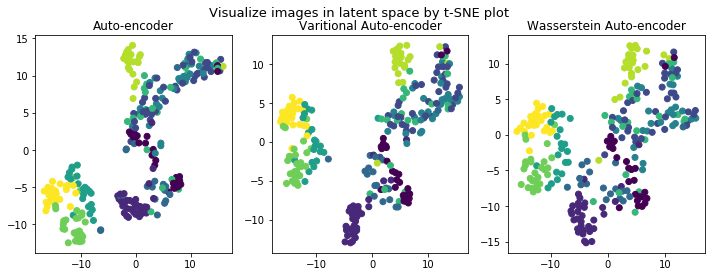

In [33]:
f, (ax1,ax2,ax3) = plt.subplots(1,3)
f.set_figheight(4)
f.set_figwidth(12)
f.suptitle("Visualize images in latent space by t-SNE plot",fontsize=13)
ax1.scatter(X_tsne_AE[:,0], X_tsne_AE[:,1], c=labels)
ax1.set_title("Auto-encoder")
ax2.scatter(X_tsne_VAE[:,0], X_tsne_VAE[:,1], c=labels)
ax2.set_title("Varitional Auto-encoder")
ax3.scatter(X_tsne_WAE[:,0], X_tsne_WAE[:,1], c=labels)
ax3.set_title("Wasserstein Auto-encoder")

In [34]:
f.savefig("images/tSNE_2d_latent_space.png", dpi=500)

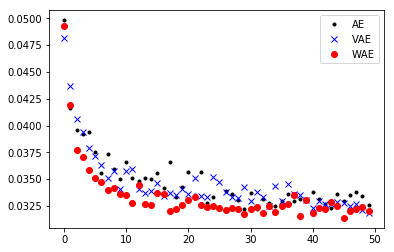

In [39]:
plt.plot(ae_recon_loss["Test"], ".k", label="AE")
plt.plot(vae_recon_loss["Test"], "xb", label="VAE")
plt.plot(wae_recon_loss["Test"], "or", label="WAE")
plt.legend(loc="best")